In [3]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd
from shapely.geometry import Point
import json
import pickle
import os
from pathlib import Path

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

path2project = "/Users/don_giraffe/Desktop/TPF/OneDrive_1_2025-6-11"
year_month = '2024-01'

plcs_with_on_off = pd.read_csv(os.path.join(path2project, 'data', 'plcs_with_on_off_jan.csv'))
stops_metadata = pd.read_csv(os.path.join(path2project, 'data', 'stops_metadata_jan.csv'))
def load_line_sequences_json(filename="line_sequences.json"):
    """Load line_sequences from JSON file"""
    filepath = f"data/{filename}"
    with open(filepath, 'r') as f:
        json_data = json.load(f)
    
    # Convert back to original format (strings to ints, lists to tuples)
    line_sequences = {}
    for line_num_str, sequences in json_data.items():
        # Handle both int and float string representations
        line_num = int(float(line_num_str))
        line_sequences[line_num] = {
            int(float(seq_id_str)): tuple(seq) for seq_id_str, seq in sequences.items()
        }
    
    print(f"✅ Loaded line_sequences from {filepath}")
    return line_sequences
line_sequences = load_line_sequences_json()

✅ Loaded line_sequences from data/line_sequences.json


In [4]:
print(plcs_with_on_off)


         Vehicle         Day              Arrival            Departure  \
0            168  2024-01-25  2024-01-25 11:11:51  2024-01-25 11:11:57   
1            168  2024-01-25  2024-01-25 11:13:45  2024-01-25 11:13:45   
2            168  2024-01-25  2024-01-25 11:14:23  2024-01-25 11:14:23   
3            168  2024-01-25  2024-01-25 11:14:56  2024-01-25 11:14:56   
4            168  2024-01-25  2024-01-25 11:15:21  2024-01-25 11:15:21   
...          ...         ...                  ...                  ...   
1226564      855  2024-01-15  2024-01-15 23:18:41  2024-01-15 23:19:04   
1226565      855  2024-01-15  2024-01-15 23:19:52  2024-01-15 23:19:52   
1226566      855  2024-01-15  2024-01-15 23:20:18  2024-01-15 23:20:26   
1226567      855  2024-01-15  2024-01-15 23:21:28  2024-01-15 23:21:37   
1226568      855  2024-01-15  2024-01-15 23:22:39  2024-01-15 23:22:39   

             Punctuality  Distance   Latitude  Longitude  Data  Timetable  \
0        0 days 00:00:57    1244.0

In [5]:
print(stops_metadata)

           Stop                       StopName    Didok  Platform Short_Name  \
0     850023801                  Bulle, Verdel  8500238         1     BULrtv   
1     850023801                  Bulle, Verdel  8500238         1     BULrtv   
2     850023801                  Bulle, Verdel  8500238         1     BULrtv   
3     850023802                  Bulle, Verdel  8500238         2     BULrtv   
4     850072901            Tramelan, garage CJ  8500729         1     DEPtra   
...         ...                            ...      ...       ...        ...   
3902  999998801              Bulle, La Léchère  9999988         1     SPElec   
3903  999998901        Bulle, Rue des Baladins  9999989         1     RUEbal   
3904  999999201  Châtel-St-Denis, Halle Triple  9999992         1     HALtri   
3905  999999201  Châtel-St-Denis, Halle Triple  9999992         1     HALtri   
3906  999999201  Châtel-St-Denis, Halle Triple  9999992         1     HALtri   

       Latitude  Longitude  Average_Del

### Waiting time

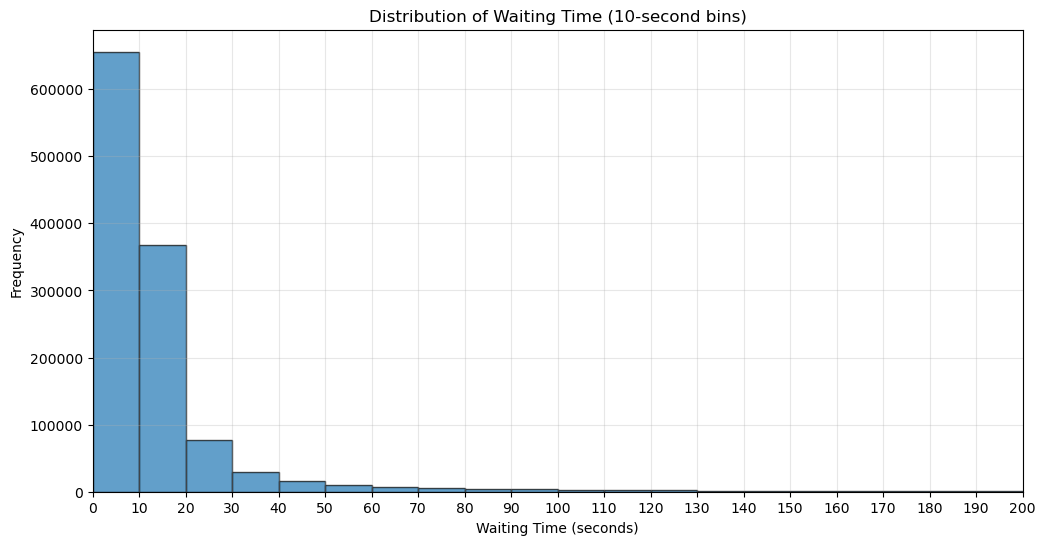

Rows with waiting time > 120 seconds: 45139
Total rows: 1226569
Percentage: 3.68%


In [6]:

# Plot distribution (limit x-axis to 200 seconds with 10-second bins)
plt.figure(figsize=(12, 6))
bins = range(0, 201, 10)  # Create bins every 10 seconds from 0 to 200
plt.hist(plcs_with_on_off['Waiting_Time_Seconds'], bins=bins, alpha=0.7, edgecolor='black')
plt.xlabel('Waiting Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Waiting Time (10-second bins)')
plt.xlim(0, 200)
plt.xticks(range(0, 201, 10))
plt.grid(True, alpha=0.3)
plt.show()

# Count rows with waiting time > 120 seconds
count_over_120 = (plcs_with_on_off['Waiting_Time_Seconds'] > 120).sum()
total_rows = len(plcs_with_on_off)

print(f"Rows with waiting time > 120 seconds: {count_over_120}")
print(f"Total rows: {total_rows}")
print(f"Percentage: {count_over_120/total_rows*100:.2f}%")

In [7]:
# Top 10 stops by passenger boarding activity (On_Second_Class only)
stops = plcs_with_on_off.groupby('StopName')['On_Second_Class'].sum()
top_10_stops = stops.nlargest(10).index.tolist()

# Top 10 lines by passenger boarding activity (On_Second_Class only)
lines = plcs_with_on_off.groupby('Line')['On_Second_Class'].sum()
top_10_lines = lines.nlargest(10).index.tolist()

print("Top 10 Stops (by boarding passengers):")
print(top_10_stops)

print("\nTop 10 Lines (by boarding passengers):")
print(top_10_lines)

Top 10 Stops (by boarding passengers):
['Fribourg/Freiburg, Pl. Gare', 'Fribourg, St-Pierre', 'Fribourg/Freiburg, gare routière', 'Fribourg, Charmettes', 'Fribourg, Tilleul/Cathédrale', 'Fribourg, Industrie', 'Marly, Grand Pré', "Bulle, Château-d'en-Bas", 'Fribourg, Boschung', 'Bulle, Place de la Gare']

Top 10 Lines (by boarding passengers):
[1.0, 2.0, 5.0, 6.0, 8.0, 3.0, 7.0, 202.0, 201.0, 4.0]


# Geo map

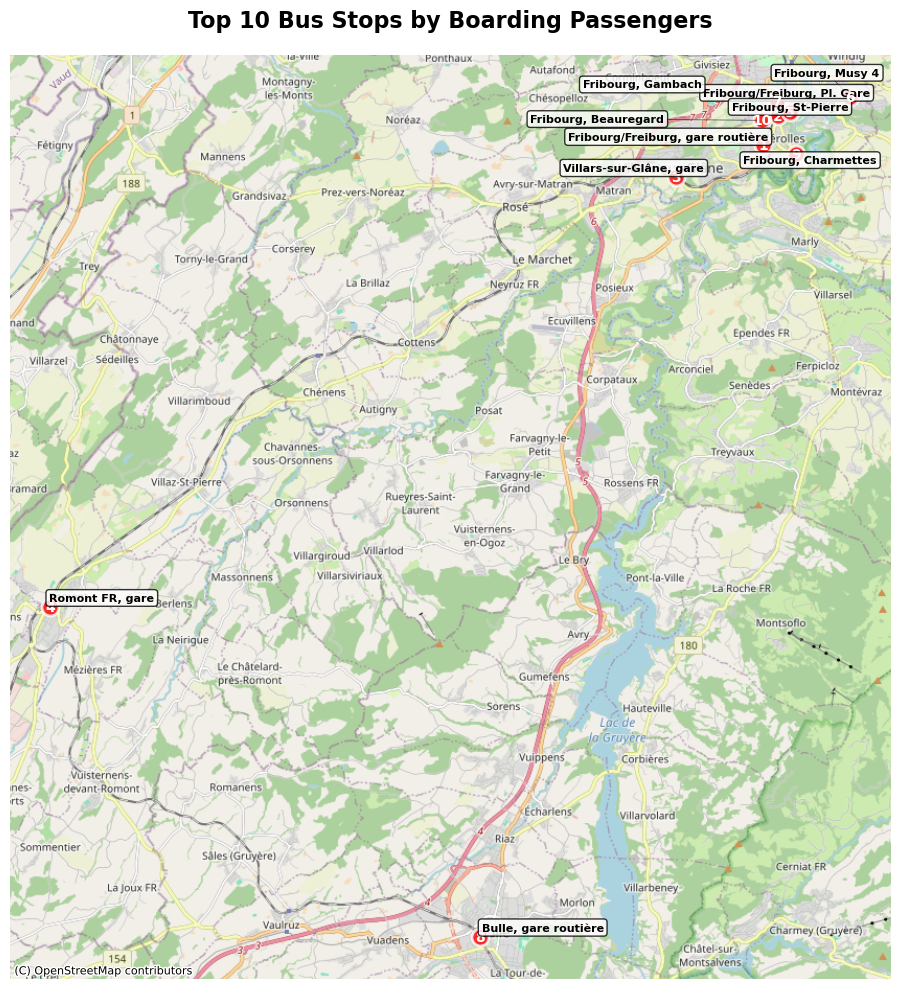

Top 10 stops by boarding passengers:
1. Fribourg/Freiburg, gare routière - 66531 boarding passengers
2. Fribourg/Freiburg, Pl. Gare - 5385 boarding passengers
3. Villars-sur-Glâne, gare - 1556 boarding passengers
4. Romont FR, gare - 1517 boarding passengers
5. Fribourg, St-Pierre - 1484 boarding passengers
6. Fribourg, Musy 4 - 1269 boarding passengers
7. Fribourg, Gambach - 1214 boarding passengers
8. Bulle, gare routière - 1197 boarding passengers
9. Fribourg, Charmettes - 1188 boarding passengers
10. Fribourg, Beauregard - 1173 boarding passengers


In [8]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point
from adjustText import adjust_text

# Get top 10 stops with coordinates (On_Second_Class only)
stops_data = plcs_with_on_off.groupby(['StopName', 'Latitude', 'Longitude'])['On_Second_Class'].sum()
top_10_stops_coords = stops_data.nlargest(10).reset_index()

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(top_10_stops_coords['Longitude'], top_10_stops_coords['Latitude'])]
gdf = gpd.GeoDataFrame(top_10_stops_coords, geometry=geometry, crs='EPSG:4326')

# Convert to Web Mercator for contextily
gdf = gdf.to_crs('EPSG:3857')

# Create plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot points
gdf.plot(ax=ax, color='red', markersize=150, alpha=0.8, edgecolor='white', linewidth=2)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Prepare text annotations
texts = []
for i, row in gdf.iterrows():
    # Add ranking number on the point
    ax.annotate(f"{i+1}", xy=(row.geometry.x, row.geometry.y),
                xytext=(0, 0), textcoords='offset points', fontsize=10,
                fontweight='bold', color='white', ha='center', va='center')
    
    # Prepare stop name text for adjustment
    text = ax.text(row.geometry.x, row.geometry.y, row['StopName'], 
                   fontsize=8, fontweight='bold', color='black',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                   ha='center', va='bottom')
    texts.append(text)

# Adjust text positions to avoid overlap
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='->', color='black', alpha=0.7, lw=0.5))

ax.set_title('Top 10 Bus Stops by Boarding Passengers', fontsize=16, fontweight='bold', pad=20)
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("Top 10 stops by boarding passengers:")
for i, row in top_10_stops_coords.iterrows():
    print(f"{i+1}. {row['StopName']} - {row['On_Second_Class']:.0f} boarding passengers")

In [9]:
# plcs_with_on_off
# TODO: see the difference between rFribourg/Freiburg, gare routière and Fribourg/Freiburg, Pl. Gare

In [10]:
n = 1
# Get top 10 lines by boarding passengers (On_Second_Class only)
lines_data = plcs_with_on_off.groupby('Line')['On_Second_Class'].sum()
top_10_lines = lines_data.nlargest(10).index.tolist()

# Filter data for top 10 lines with direction "n" only
line_drawing_df = plcs_with_on_off[
    (plcs_with_on_off['Line'].isin(top_10_lines)) & 
    (plcs_with_on_off['Direction'] == n)
][['Line', 'StopSeq', 'StopName', 'Latitude', 'Longitude']].copy()

# Remove duplicates based on Line and StopName combination, keep first occurrence
line_drawing_df = line_drawing_df.drop_duplicates(subset=['Line', 'StopName']).sort_values(['Line', 'StopSeq']).reset_index(drop=True)

print(f"DataFrame shape: {line_drawing_df.shape}")
print(f"Lines included: {sorted(line_drawing_df['Line'].unique())}")
print("\nFirst few rows:")
print(line_drawing_df.head(10))

# Check uniqueness per line
# print("\nStops per line:")
# for line in sorted(line_drawing_df['Line'].unique()):
#     stops_count = len(line_drawing_df[line_drawing_df['Line'] == line])
#     print(f"Line {line}: {stops_count} unique stops")

DataFrame shape: (167, 5)
Lines included: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 201.0, 202.0]

First few rows:
   Line  StopSeq                        StopName   Latitude  Longitude
0   1.0      1.0           Givisiez, Mont Carmel  46.811680   7.137280
1   1.0      2.0        Fribourg, Jura Chassotte  46.810813   7.139390
2   1.0      3.0          Fribourg, Champ-Fleuri  46.809245   7.140911
3   1.0      4.0   Fribourg, Champ-des-Fontaines  46.809011   7.142340
4   1.0      5.0                Fribourg, Vuille  46.809468   7.145806
5   1.0      6.0           Fribourg, Ste-Thérèse  46.809375   7.149365
6   1.0      7.0           Fribourg, Miséricorde  46.808376   7.151501
7   1.0      8.0            Fribourg, Université  46.806581   7.153425
8   1.0      9.0  Fribourg, Place Georges Python  46.804706   7.155651
9   1.0     10.0             Fribourg, St-Pierre  46.804568   7.155800


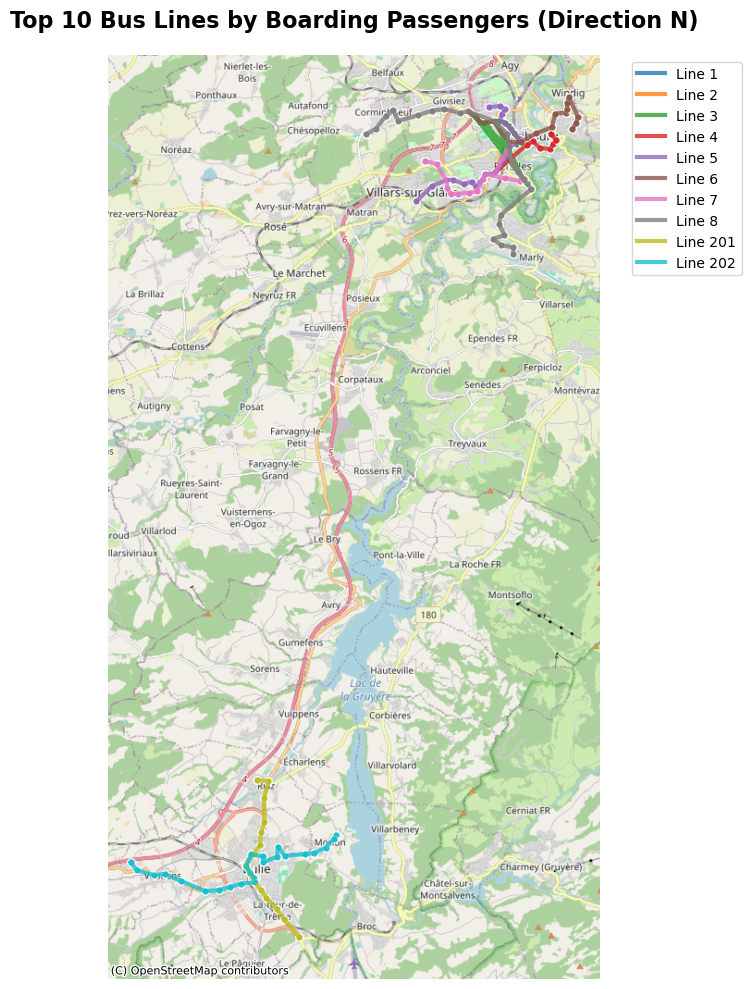

Top 10 lines by boarding passengers:
1. Line 1 - 295637 boarding passengers
2. Line 2 - 261792 boarding passengers
3. Line 3 - 80720 boarding passengers
4. Line 4 - 38412 boarding passengers
5. Line 5 - 225194 boarding passengers
6. Line 6 - 146115 boarding passengers
7. Line 7 - 69403 boarding passengers
8. Line 8 - 119318 boarding passengers
9. Line 201 - 59753 boarding passengers
10. Line 202 - 63081 boarding passengers


In [11]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.colors as mcolors

# Create GeoDataFrame from line_drawing_df
geometry = [Point(xy) for xy in zip(line_drawing_df['Longitude'], line_drawing_df['Latitude'])]
gdf = gpd.GeoDataFrame(line_drawing_df, geometry=geometry, crs='EPSG:4326')

# Convert to Web Mercator for contextily
gdf = gdf.to_crs('EPSG:3857')

# Create plot
fig, ax = plt.subplots(figsize=(15, 10))

# Generate distinct colors for each line
unique_lines = sorted(gdf['Line'].unique())
colors = plt.cm.tab10(range(len(unique_lines)))
line_colors = dict(zip(unique_lines, colors))

# Plot each line
for line_num in unique_lines:
    line_data = gdf[gdf['Line'] == line_num].sort_values('StopSeq')
    
    if len(line_data) > 1:  # Need at least 2 points to draw a line
        # Create LineString from the coordinates
        coords = [(row.geometry.x, row.geometry.y) for _, row in line_data.iterrows()]
        line_geom = LineString(coords)
        
        # Plot the line
        ax.plot(*line_geom.xy, color=line_colors[line_num], linewidth=3, 
                alpha=0.8, label=f'Line {int(line_num)}')
        
        # Plot the stops as small points
        line_data.plot(ax=ax, color=line_colors[line_num], markersize=30, 
                      alpha=0.9, edgecolor='white', linewidth=1)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

ax.set_title('Top 10 Bus Lines by Boarding Passengers (Direction N)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("Top 10 lines by boarding passengers:")
for i, line in enumerate(unique_lines, 1):
    total_passengers = lines_data[line]
    print(f"{i}. Line {int(line)} - {total_passengers:.0f} boarding passengers")

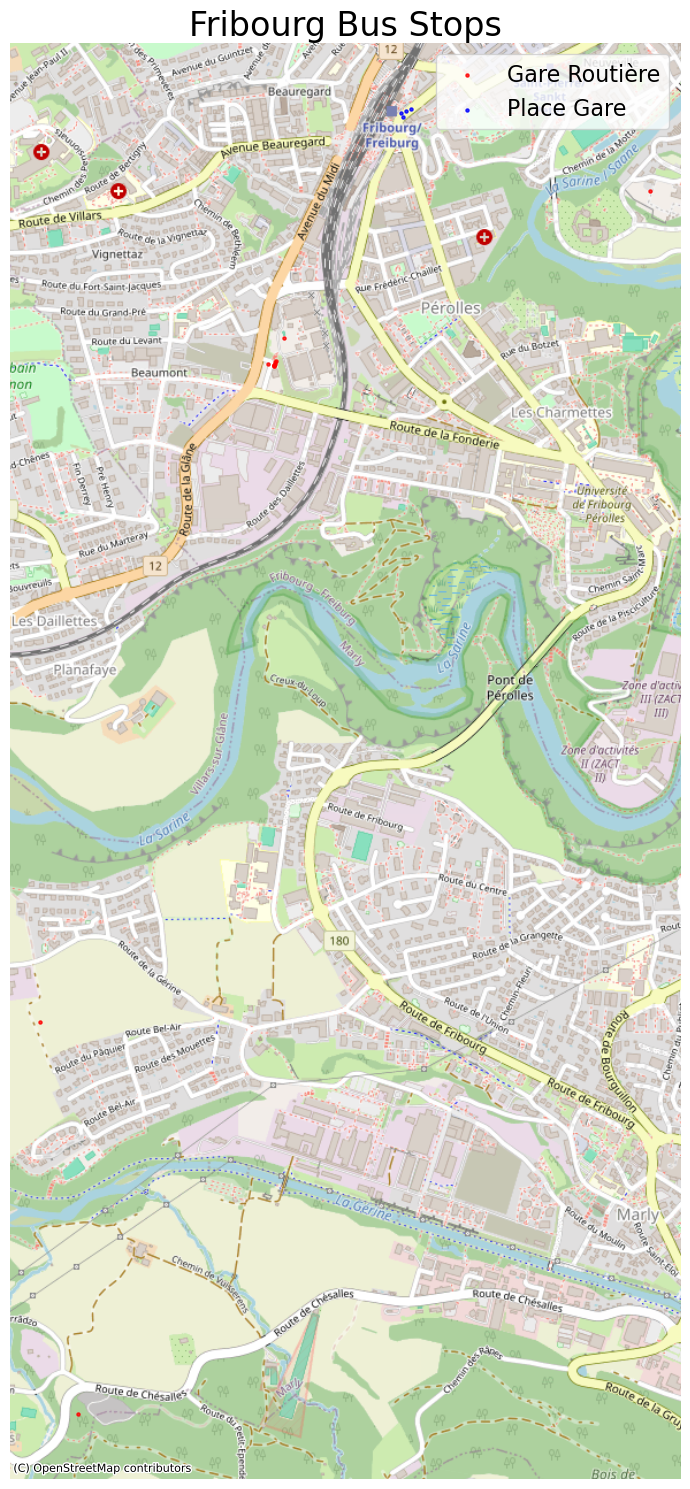

Found 16 unique stops
           Stop                          StopName  On_Second_Class
0   850488111.0  Fribourg/Freiburg, gare routière          5660.87
1   850488112.0  Fribourg/Freiburg, gare routière          9961.18
2   850488114.0  Fribourg/Freiburg, gare routière          8342.76
3   850488115.0  Fribourg/Freiburg, gare routière          4948.61
4   850488116.0  Fribourg/Freiburg, gare routière          3361.56
5   850488117.0  Fribourg/Freiburg, gare routière          3823.29
6   850488118.0  Fribourg/Freiburg, gare routière          2852.05
7   850488119.0  Fribourg/Freiburg, gare routière          7815.24
8   850488120.0  Fribourg/Freiburg, gare routière          4562.36
9   850488121.0  Fribourg/Freiburg, gare routière          8265.52
10  850488122.0  Fribourg/Freiburg, gare routière          5000.68
11  850488125.0  Fribourg/Freiburg, gare routière          4791.45
12  859237402.0       Fribourg/Freiburg, Pl. Gare             0.00
13  859237411.0       Fribourg/Freiburg,

In [33]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point

# Filter for Fribourg stations
fribourg_stops = plcs_with_on_off[
    plcs_with_on_off['StopName'].str.contains('Fribourg/Freiburg, gare routière|Fribourg/Freiburg, Pl. Gare', na=False)
]

# Average coordinates by Stop ID
stop_summary = fribourg_stops.groupby(['Stop', 'StopName']).agg({
    'Latitude': 'mean',
    'Longitude': 'mean',
    'On_Second_Class': 'sum'
}).reset_index()

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(stop_summary['Longitude'], stop_summary['Latitude'])]
gdf = gpd.GeoDataFrame(stop_summary, geometry=geometry, crs='EPSG:4326')

# Convert to Web Mercator
gdf = gdf.to_crs('EPSG:3857')

# Create big plot
fig, ax = plt.subplots(figsize=(20, 15))

# Plot different stations with different colors
gare_routiere = gdf[gdf['StopName'].str.contains('gare routière')]
pl_gare = gdf[gdf['StopName'].str.contains('Pl. Gare')]

if not gare_routiere.empty:
    gare_routiere.plot(ax=ax, color='red', markersize=5, alpha=0.8, label='Gare Routière')

if not pl_gare.empty:
    pl_gare.plot(ax=ax, color='blue', markersize=5, alpha=0.8, label='Place Gare')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add stop IDs as labels
# for _, row in gdf.iterrows():
#     ax.annotate(f"{row['Stop']}", 
#                 xy=(row.geometry.x, row.geometry.y),
#                 fontsize=14, ha='center', color='white', weight='bold')

ax.set_title('Fribourg Bus Stops', fontsize=24)
ax.legend(fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()

print(f"Found {len(stop_summary)} unique stops")
print(stop_summary[['Stop', 'StopName', 'On_Second_Class']])

In [12]:
plcs_with_on_off

Vehicle         Day              Arrival            Departure  \
0            168  2024-01-25  2024-01-25 11:11:51  2024-01-25 11:11:57   
1            168  2024-01-25  2024-01-25 11:13:45  2024-01-25 11:13:45   
2            168  2024-01-25  2024-01-25 11:14:23  2024-01-25 11:14:23   
3            168  2024-01-25  2024-01-25 11:14:56  2024-01-25 11:14:56   
4            168  2024-01-25  2024-01-25 11:15:21  2024-01-25 11:15:21   
...          ...         ...                  ...                  ...   
1226564      855  2024-01-15  2024-01-15 23:18:41  2024-01-15 23:19:04   
1226565      855  2024-01-15  2024-01-15 23:19:52  2024-01-15 23:19:52   
1226566      855  2024-01-15  2024-01-15 23:20:18  2024-01-15 23:20:26   
1226567      855  2024-01-15  2024-01-15 23:21:28  2024-01-15 23:21:37   
1226568      855  2024-01-15  2024-01-15 23:22:39  2024-01-15 23:22:39   

             Punctuality  Distance   Latitude  Longitude  Data  Timetable  \
0        0 days 00:00:57    1244.0  46.796830   7.146135   263        4.0   
1        0 days 00:01:45     562.0  46.792828   7.143368   263        4.0   
2        0 days 00:01:23     362.0  46.790860   7.140273   263        4.0   
3        0 days 00:01:26     303.0  46.789941   7.136855   263        4.0   
4        0 days 00:01:21     350.0  46.788863   7.132995   263        4.0   
...                  ...       ...        ...        ...   ...        ...   
1226564  0 days 00:00:34     140.0  46.615696   7.057483   262        1.0   
1226565  0 days 00:00:52     342.0  46.613355   7.059940   262        1.0   
1226566  0 days 00:00:56     233.0  46.611631   7.061700   262        1.0   
1226567  0 days 00:01:37     469.0  46.608675   7.065711   262        1.0   
1226568  0 days 00:00:39     485.0  46.605475   7.069248   262        1.0   

          Block  JourneySeq   Line  Journey  StopSeq         Stop  \
0        1025.0         7.0  336.0  33635.0      2.0  858885902.0   
1        1025.0         7.0  336.0  33635.0      3.0  850463301.0   
2        1025.0         7.0  336.0  33635.0      4.0  850463401.0   
3        1025.0         7.0  336.0  33635.0      5.0  850428101.0   
4        1025.0         7.0  336.0  33635.0      6.0  850462301.0   
...         ...         ...    ...      ...      ...          ...   
1226564  1508.0        43.0  201.0  20924.0     11.0  859328201.0   
1226565  1508.0        43.0  201.0  20924.0     12.0  857773001.0   
1226566  1508.0        43.0  201.0  20924.0     13.0  859328801.0   
1226567  1508.0        43.0  201.0  20924.0     14.0  857773101.0   
1226568  1508.0        43.0  201.0  20924.0     15.0  859328701.0   

                              StopName  Punctuality_Seconds    Didok  \
0                Fribourg, bluefactory                 57.0  8588859   
1            Fribourg, Rte de la Glâne                105.0  8504633   
2        Villars-sur-Glâne, Le Moléson                 83.0  8504634   
3        Villars-sur-Glâne, Daillettes                 86.0  8504281   
4         Villars-sur-Glâne, Planafaye                 81.0  8504623   
...                                ...                  ...      ...   
1226564                Bulle, St-Denis                 34.0  8593282   
1226565          Bulle, jardin Anglais                 52.0  8577730   
1226566    La Tour-de-Trême, St-Michel                 56.0  8593288   
1226567       La Tour-de-Trême, Centre                 97.0  8577731   
1226568       La Tour-de-Trême, Le Pra                 39.0  8593287   

         On_Second_Class  Off_Second_Class    Day_Type     Waiting_Time  \
0                   1.23              0.06  lu-ve-scol  0 days 00:00:06   
1                   0.15              0.06  lu-ve-scol  0 days 00:00:00   
2                   1.02              0.34  lu-ve-scol  0 days 00:00:00   
3                   0.71              0.72  lu-ve-scol  0 days 00:00:00   
4                   0.26              0.37  lu-ve-scol  0 days 00:00:00   
...                  ...               ...         

In [13]:
stops_metadata


Stop                       StopName    Didok  Platform Short_Name  \
0     850023801                  Bulle, Verdel  8500238         1     BULrtv   
1     850023801                  Bulle, Verdel  8500238         1     BULrtv   
2     850023801                  Bulle, Verdel  8500238         1     BULrtv   
3     850023802                  Bulle, Verdel  8500238         2     BULrtv   
4     850072901            Tramelan, garage CJ  8500729         1     DEPtra   
...         ...                            ...      ...       ...        ...   
3902  999998801              Bulle, La Léchère  9999988         1     SPElec   
3903  999998901        Bulle, Rue des Baladins  9999989         1     RUEbal   
3904  999999201  Châtel-St-Denis, Halle Triple  9999992         1     HALtri   
3905  999999201  Châtel-St-Denis, Halle Triple  9999992         1     HALtri   
3906  999999201  Châtel-St-Denis, Halle Triple  9999992         1     HALtri   

       Latitude  Longitude  Average_Delay_Seconds  P90_Delay_Seconds  \
0     46.625099   7.066065             189.367052              341.0   
1     46.625099   7.066065             189.367052              341.0   
2     46.625099   7.066065             189.367052              341.0   
3     46.624744   7.065967             132.812908              199.2   
4     47.246393   7.233253            1015.300000             1900.4   
...         ...        ...                    ...                ...   
3902  46.617665   7.045063             660.227273              952.4   
3903  46.610138   7.047311             -38.058824               77.7   
3904  46.536425   6.897592              26.892116              223.0   
3905  46.536425   6.897592              26.892116              223.0   
3906  46.536425   6.897592              26.892116              223.0   

      P50_Delay_Seconds  P10_Delay_Seconds   Line  Line_Avg_Delay_Seconds  \
0                 161.0               69.0  202.0              190.501837   
1                 161.0               69.0  280.0               33.555556   
2                 161.0               69.0  331.0              179.214286   
3                 120.0               74.8  202.0              132.812908   
4                 742.5              348.7  909.0              998.888889   
...                 ...                ...    ...                     ...   
3902              573.5              371.6  901.0              660.227273   
3903              -63.0             -150.2  901.0              -38.058824   
3904               25.0             -168.0  481.0              133.600000   
3905               25.0             -168.0  492.0              -49.090909   
3906               25.0             -168.0  902.0               12.025641   

      Line_P90_Delay_Seconds  Line_P50_Delay_Seconds  Line_P10_Delay_Seconds  
0                      341.0                   162.0                    70.0  
1                      143.6                    43.0                   -73.8  
2                      326.0                   150.0                    69.1  
3                      199.2                   120.0                    74.8  
4                     1973.2                   478.0                   348.1  
...                      ...                     ...                     ...  
3902                   952.4                   573.5                   371.6  
3903                    77.7                   -63.0                  -150.2  
3904                   479.0                    94.0                  -175.2  
3905                   224.0                  -122.0                  -210.0  
3906                   184.6                    24.0                  -138.0  

[3907 rows x 16 columns]

# Important lines & stops

Analyzing bus line demand using DAILY AVERAGES...
1. DAILY AVERAGE DEMAND ANALYSIS BY BUS LINE (BOARDING ONLY)

Data period: 2024-01-08 to 2024-02-01
Total unique days in dataset: 22

Summary by Bus Line (Average Daily Boarding):
        Avg_Daily_Boarding  Avg_Daily_Vehicles  Avg_Daily_Journeys  \
Line                                                                 
1.0               13438.03               12.77              225.32   
2.0               11899.63               12.50              232.05   
5.0               10236.10                8.68              211.27   
6.0                6641.59                6.82              122.86   
8.0                5423.54                7.41              122.18   
...                    ...                 ...                 ...   
903.0                96.06                3.28                3.78   
13.0                 95.53                6.56               31.44   
901.0                93.67                2.72                3.00   


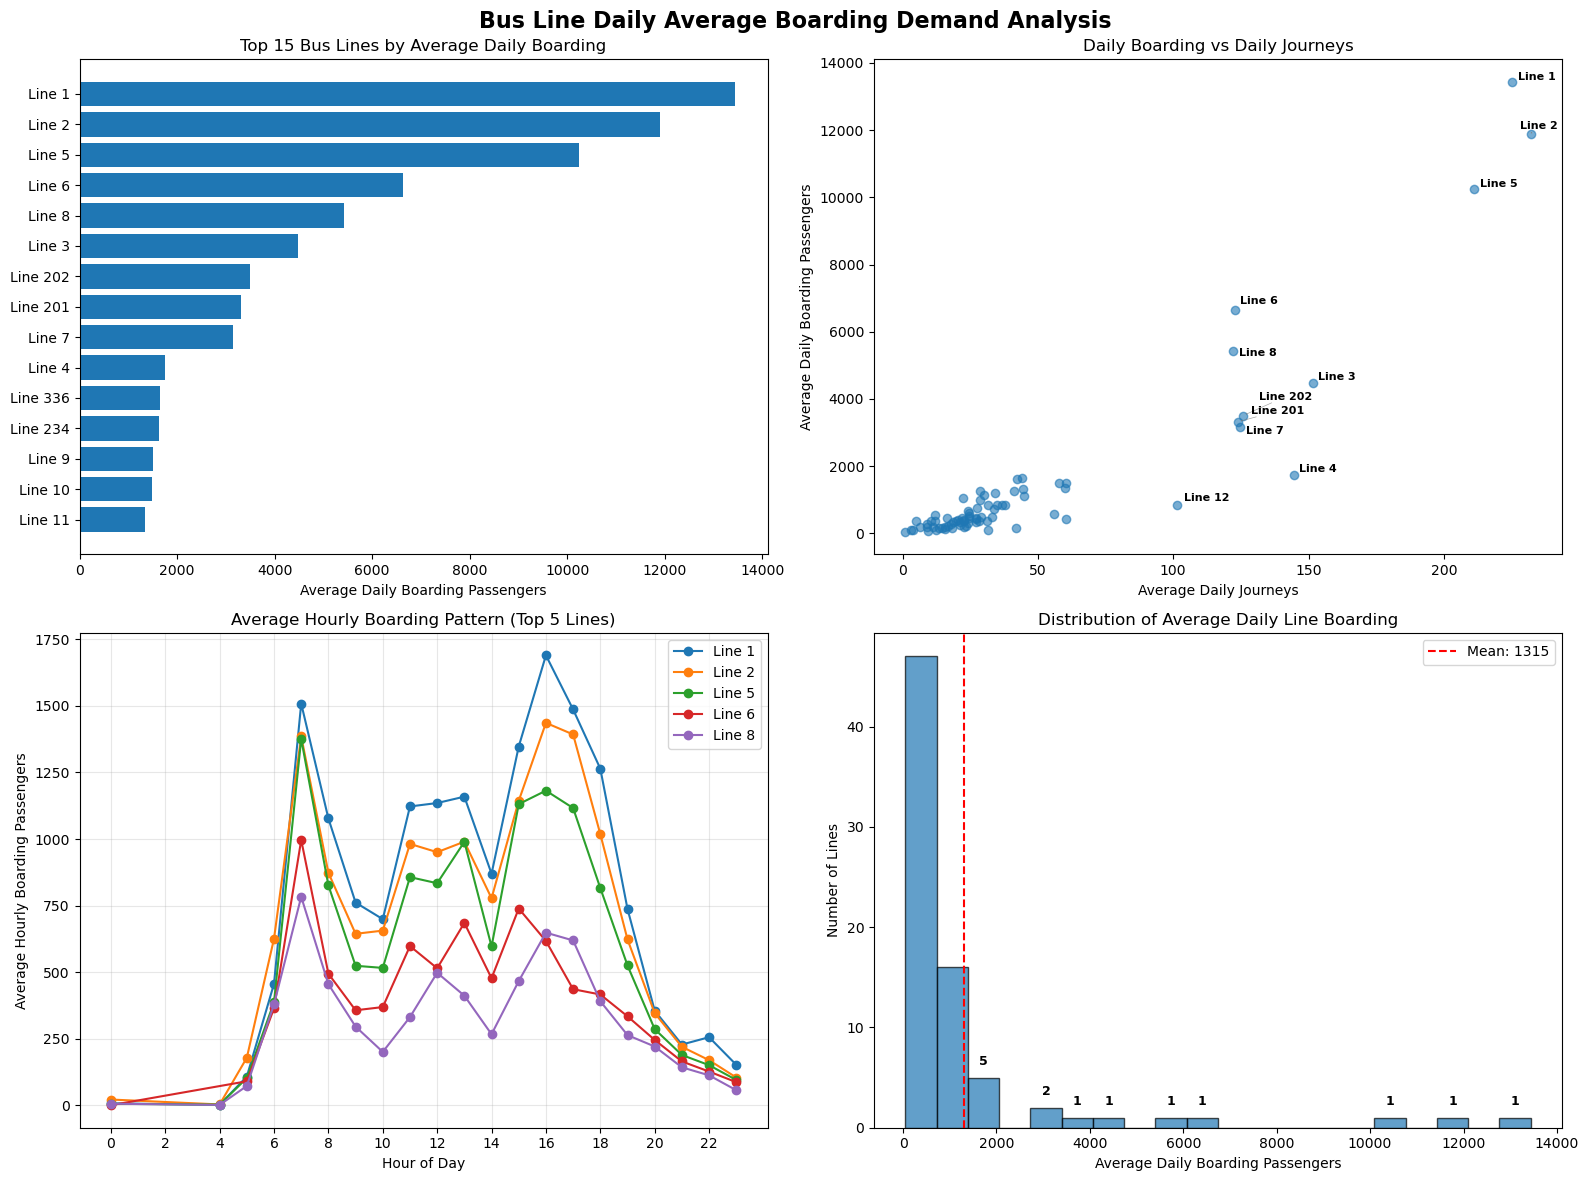

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np



def analyze_bus_line_demand(df):
    """
    Comprehensive analysis of bus line demand - Daily average boarding passengers only
    """
    
    # Convert Arrival column to datetime if it's not already
    df['Arrival'] = pd.to_datetime(df['Arrival'])
    df['Hour'] = df['Arrival'].dt.hour
    df['Date'] = df['Arrival'].dt.date
    
    # 1. Basic demand analysis per line (daily average boarding only)
    print("=" * 60)
    print("1. DAILY AVERAGE DEMAND ANALYSIS BY BUS LINE (BOARDING ONLY)")
    print("=" * 60)
    
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
        
    df_reset['Date'] = pd.to_datetime(df_reset['Arrival']).dt.date
    
    # Calculate daily totals first, then average
    daily_line_demand = df_reset.groupby(['Line', 'Date']).agg({
        'On_Second_Class': 'sum',
        'Vehicle': 'nunique',  # Number of unique vehicles per day
        'Journey': 'nunique'   # Number of unique journeys per day
    })
    
    # Calculate average daily demand for each line
    line_demand = daily_line_demand.groupby('Line').agg({
        'On_Second_Class': 'mean',  # Average daily boarding
        'Vehicle': 'mean',          # Average unique vehicles per day  
        'Journey': 'mean'           # Average unique journeys per day
    }).round(2)
    
    # Rename columns for clarity
    line_demand.columns = ['Avg_Daily_Boarding', 'Avg_Daily_Vehicles', 'Avg_Daily_Journeys']
    
    # Add total days of operation for each line
    days_per_line = daily_line_demand.groupby('Line').size()
    line_demand['Operating_Days'] = days_per_line
    
    print(f"\nData period: {df_reset['Date'].min()} to {df_reset['Date'].max()}")
    print(f"Total unique days in dataset: {df_reset['Date'].nunique()}")
    print("\nSummary by Bus Line (Average Daily Boarding):")
    print(line_demand.sort_values('Avg_Daily_Boarding', ascending=False))
    
    # 2a. Demand during the day (hourly analysis) - daily averages
    print("\n" + "=" * 60)
    print("2A. HOURLY BOARDING PATTERNS BY LINE (DAILY AVERAGES)")
    print("=" * 60)
    
    # Create hourly demand analysis - daily averages
    daily_hourly_demand = df_reset.groupby(['Line', 'Date', 'Hour']).agg({
        'On_Second_Class': 'sum'
    })
    
    # Calculate average hourly demand across all days
    hourly_demand = daily_hourly_demand.groupby(['Line', 'Hour']).agg({
        'On_Second_Class': 'mean'
    }).round(2)
    
    hourly_demand.columns = ['Avg_Hourly_Boarding']
    
    # Reset index for easier plotting
    hourly_demand_reset = hourly_demand.reset_index()
    
    print("\nSample of average hourly boarding demand (first few lines and hours):")
    print(hourly_demand.head(20))
    
    # 2b. Daily boarding summary
    print("\n" + "=" * 60)
    print("2B. DAILY AVERAGE BOARDING BY LINE")
    print("=" * 60)
    
    # Calculate daily averages for boarding summary
    daily_boarding_summary = df_reset.groupby(['Line', 'Date']).agg({
        'On_Second_Class': ['sum', 'mean', 'count']
    })
    
    boarding_summary = daily_boarding_summary.groupby('Line').agg({
        ('On_Second_Class', 'sum'): 'mean',     # Average daily total boarding
        ('On_Second_Class', 'mean'): 'mean',    # Average boarding per stop
        ('On_Second_Class', 'count'): 'mean'    # Average daily records
    }).round(2)
    
    # Flatten column names
    boarding_summary.columns = ['Avg_Daily_Boarding', 'Avg_Boarding_Per_Stop', 'Avg_Daily_Records']
    
    print("\nDaily Average Boarding Analysis:")
    print(boarding_summary.sort_values('Avg_Daily_Boarding', ascending=False))
    
    # 3. Rank bus lines based on daily average boarding demand
    print("\n" + "=" * 60)
    print("3. BUS LINE RANKING BY DAILY AVERAGE BOARDING DEMAND")
    print("=" * 60)
    
    # Create comprehensive ranking
    ranking_df = line_demand.copy()
    ranking_df['Demand_Rank'] = ranking_df['Avg_Daily_Boarding'].rank(ascending=False)
    
    # Sort by average daily boarding (primary ranking metric)
    ranking_df = ranking_df.sort_values('Avg_Daily_Boarding', ascending=False)
    ranking_df['Overall_Rank'] = range(1, len(ranking_df) + 1)
    
    print("\nBus Line Rankings by Average Daily Boarding (Top 20):")
    print(ranking_df[['Avg_Daily_Boarding', 'Avg_Daily_Vehicles', 'Avg_Daily_Journeys', 
                     'Operating_Days', 'Overall_Rank']].head(20))
    
    return line_demand, hourly_demand_reset, ranking_df

def create_visualizations(df, line_demand, hourly_demand_reset, ranking_df):
    """
    Create visualizations for the daily average boarding demand analysis
    """
    
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Bus Line Daily Average Boarding Demand Analysis', fontsize=16, fontweight='bold')
    
    # 1. Top 15 lines by average daily boarding
    top_lines = ranking_df.head(15)
    axes[0, 0].barh(range(len(top_lines)), top_lines['Avg_Daily_Boarding'])
    axes[0, 0].set_yticks(range(len(top_lines)))
    axes[0, 0].set_yticklabels([f"Line {int(line)}" for line in top_lines.index])
    axes[0, 0].set_xlabel('Average Daily Boarding Passengers')
    axes[0, 0].set_title('Top 15 Bus Lines by Average Daily Boarding')
    axes[0, 0].invert_yaxis()
    
    # 2. Average Daily Boarding vs Average Daily Journeys scatter plot
    axes[0, 1].scatter(ranking_df['Avg_Daily_Journeys'], ranking_df['Avg_Daily_Boarding'], alpha=0.6)
    axes[0, 1].set_xlabel('Average Daily Journeys')
    axes[0, 1].set_ylabel('Average Daily Boarding Passengers')
    axes[0, 1].set_title('Daily Boarding vs Daily Journeys')
    
    # Add text labels for lines with more than 100 average daily journeys
    try:
        from adjustText import adjust_text
        texts = []
        for line, row in ranking_df.iterrows():
            if row['Avg_Daily_Journeys'] > 100:
                text = axes[0, 1].text(row['Avg_Daily_Journeys'], row['Avg_Daily_Boarding'], 
                                     f'Line {int(line)}', fontsize=8, fontweight='bold')
                texts.append(text)
        
        # Adjust text positions to avoid overlap
        if texts:
            adjust_text(texts, ax=axes[0, 1], 
                       arrowprops=dict(arrowstyle='->', color='gray', alpha=0.7, lw=0.5))
    except ImportError:
        # Fallback if adjustText is not available
        for line, row in ranking_df.iterrows():
            if row['Avg_Daily_Journeys'] > 100:
                axes[0, 1].annotate(f'Line {int(line)}', (row['Avg_Daily_Journeys'], row['Avg_Daily_Boarding']), 
                                  fontsize=8, fontweight='bold',
                                  xytext=(5, 5), textcoords='offset points')
    
    # 3. Hourly boarding pattern for top 5 lines (daily averages)
    top_5_lines = ranking_df.head(5).index
    for line in top_5_lines:
        line_hourly = hourly_demand_reset[hourly_demand_reset['Line'] == line]
        if not line_hourly.empty:
            axes[1, 0].plot(line_hourly['Hour'], line_hourly['Avg_Hourly_Boarding'], 
                           marker='o', label=f'Line {int(line)}')
    
    axes[1, 0].set_xlabel('Hour of Day')
    axes[1, 0].set_ylabel('Average Hourly Boarding Passengers')
    axes[1, 0].set_title('Average Hourly Boarding Pattern (Top 5 Lines)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xticks(range(0, 24, 2))
    
    # 4. Distribution of average daily line boarding demands
    n, bins, patches = axes[1, 1].hist(ranking_df['Avg_Daily_Boarding'], bins=20, edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Average Daily Boarding Passengers')
    axes[1, 1].set_ylabel('Number of Lines')
    axes[1, 1].set_title('Distribution of Average Daily Line Boarding')
    axes[1, 1].axvline(ranking_df['Avg_Daily_Boarding'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {ranking_df["Avg_Daily_Boarding"].mean():.0f}')
    
    # Add text above bars for bins with high daily averages (adjusted threshold)
    high_avg_threshold = ranking_df['Avg_Daily_Boarding'].quantile(0.8)  # Top 20%
    for i, (count, left_edge, right_edge) in enumerate(zip(n, bins[:-1], bins[1:])):
        if left_edge > high_avg_threshold and count > 0:
            # Position text at the center of the bin, above the bar
            x_pos = (left_edge + right_edge) / 2
            y_pos = count + max(n) * 0.02  # Slightly above the bar
            axes[1, 1].text(x_pos, y_pos, f'{int(count)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

def generate_peak_hours_analysis(df):
    """
    Additional analysis for peak hours (daily average boarding only)
    """
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    df_reset['Hour'] = pd.to_datetime(df_reset['Arrival']).dt.hour
    df_reset['Date'] = pd.to_datetime(df_reset['Arrival']).dt.date
    
    # Calculate daily hourly totals, then average
    daily_hourly_total = df_reset.groupby(['Date', 'Hour'])['On_Second_Class'].sum()
    hourly_average = daily_hourly_total.groupby('Hour').mean()
    peak_hours = hourly_average.nlargest(3)
    
    print("\n" + "=" * 60)
    print("PEAK HOURS ANALYSIS (DAILY AVERAGE BOARDING ONLY)")
    print("=" * 60)
    print(f"\nTop 3 Peak Hours (system-wide daily averages):")
    for hour, demand in peak_hours.items():
        print(f"Hour {hour:02d}:00 - {demand:.1f} average daily boardings")
    
    # Peak hours by line (for top 10 lines by daily average)
    daily_line_totals = df_reset.groupby(['Line', 'Date'])['On_Second_Class'].sum()
    avg_daily_by_line = daily_line_totals.groupby('Line').mean()
    top_10_lines = avg_daily_by_line.nlargest(10).index
    
    print(f"\nPeak hour for each of the top 10 busiest lines (by daily average):")
    for line in top_10_lines:
        line_data = df_reset[df_reset['Line'] == line]
        # Calculate daily hourly averages for this line
        daily_line_hourly = line_data.groupby(['Date', 'Hour'])['On_Second_Class'].sum()
        line_hourly_avg = daily_line_hourly.groupby('Hour').mean()
        
        if not line_hourly_avg.empty:
            peak_hour = line_hourly_avg.idxmax()
            peak_demand = line_hourly_avg.max()
            print(f"Line {int(line)}: Peak at {peak_hour:02d}:00 with {peak_demand:.1f} avg daily boardings")

# Example usage:
# Uncomment and run the following lines with your dataframe

# line_demand, hourly_demand, ranking = analyze_bus_line_demand(plcs_with_on_off)
# create_visualizations(plcs_with_on_off, line_demand, hourly_demand, ranking)
# generate_peak_hours_analysis(plcs_with_on_off)

# Additional quick summary function
def quick_summary(df):
    """
    Quick summary statistics (daily averages for boarding only)
    """
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    df_reset['Date'] = pd.to_datetime(df_reset['Arrival']).dt.date
    total_days = df_reset['Date'].nunique()
    total_boardings = df_reset['On_Second_Class'].sum()
    
    print("\nQUICK SUMMARY (DAILY AVERAGES - BOARDING ONLY)")
    print("=" * 50)
    print(f"Total unique bus lines: {df_reset['Line'].nunique()}")
    print(f"Total unique vehicles: {df_reset['Vehicle'].nunique()}")
    print(f"Total days in dataset: {total_days}")
    print(f"Total passenger boardings: {total_boardings:,.0f}")
    print(f"Average daily boardings (system-wide): {total_boardings/total_days:,.0f}")
    print(f"Average boardings per stop: {df_reset['On_Second_Class'].mean():.2f}")
    print(f"Date range: {df_reset['Date'].min()} to {df_reset['Date'].max()}")
    
# Run the main analysis
print("Analyzing bus line demand using DAILY AVERAGES...")
line_demand, hourly_demand, ranking = analyze_bus_line_demand(plcs_with_on_off)

# Create visualizations
create_visualizations(plcs_with_on_off, line_demand, hourly_demand, ranking)

# # Generate peak hours analysis
# generate_peak_hours_analysis(plcs_with_on_off)

# # Get quick summary
# quick_summary(plcs_with_on_off)

Analyzing bus stop demand using DAILY AVERAGES...
1. DAILY AVERAGE DEMAND ANALYSIS BY BUS STOP (BOARDING ONLY)

Data period: 2024-01-08 to 2024-02-01
Total unique days in dataset: 22

Summary by Bus Stop - Average Daily Boarding (Top 20):
                                  Avg_Daily_Boarding  Avg_Daily_Vehicles  \
StopName                                                                   
Fribourg/Freiburg, Pl. Gare                 15948.93               44.82   
Fribourg, St-Pierre                          3909.46               33.68   
Fribourg/Freiburg, gare routière             3153.89               68.73   
Fribourg, Charmettes                         3049.50               67.14   
Fribourg, Tilleul/Cathédrale                 2755.17               55.32   
Fribourg, Industrie                          2049.68               29.86   
Marly, Grand Pré                             1597.96               52.36   
Bulle, Place de la Gare                      1362.82                8.33   
B

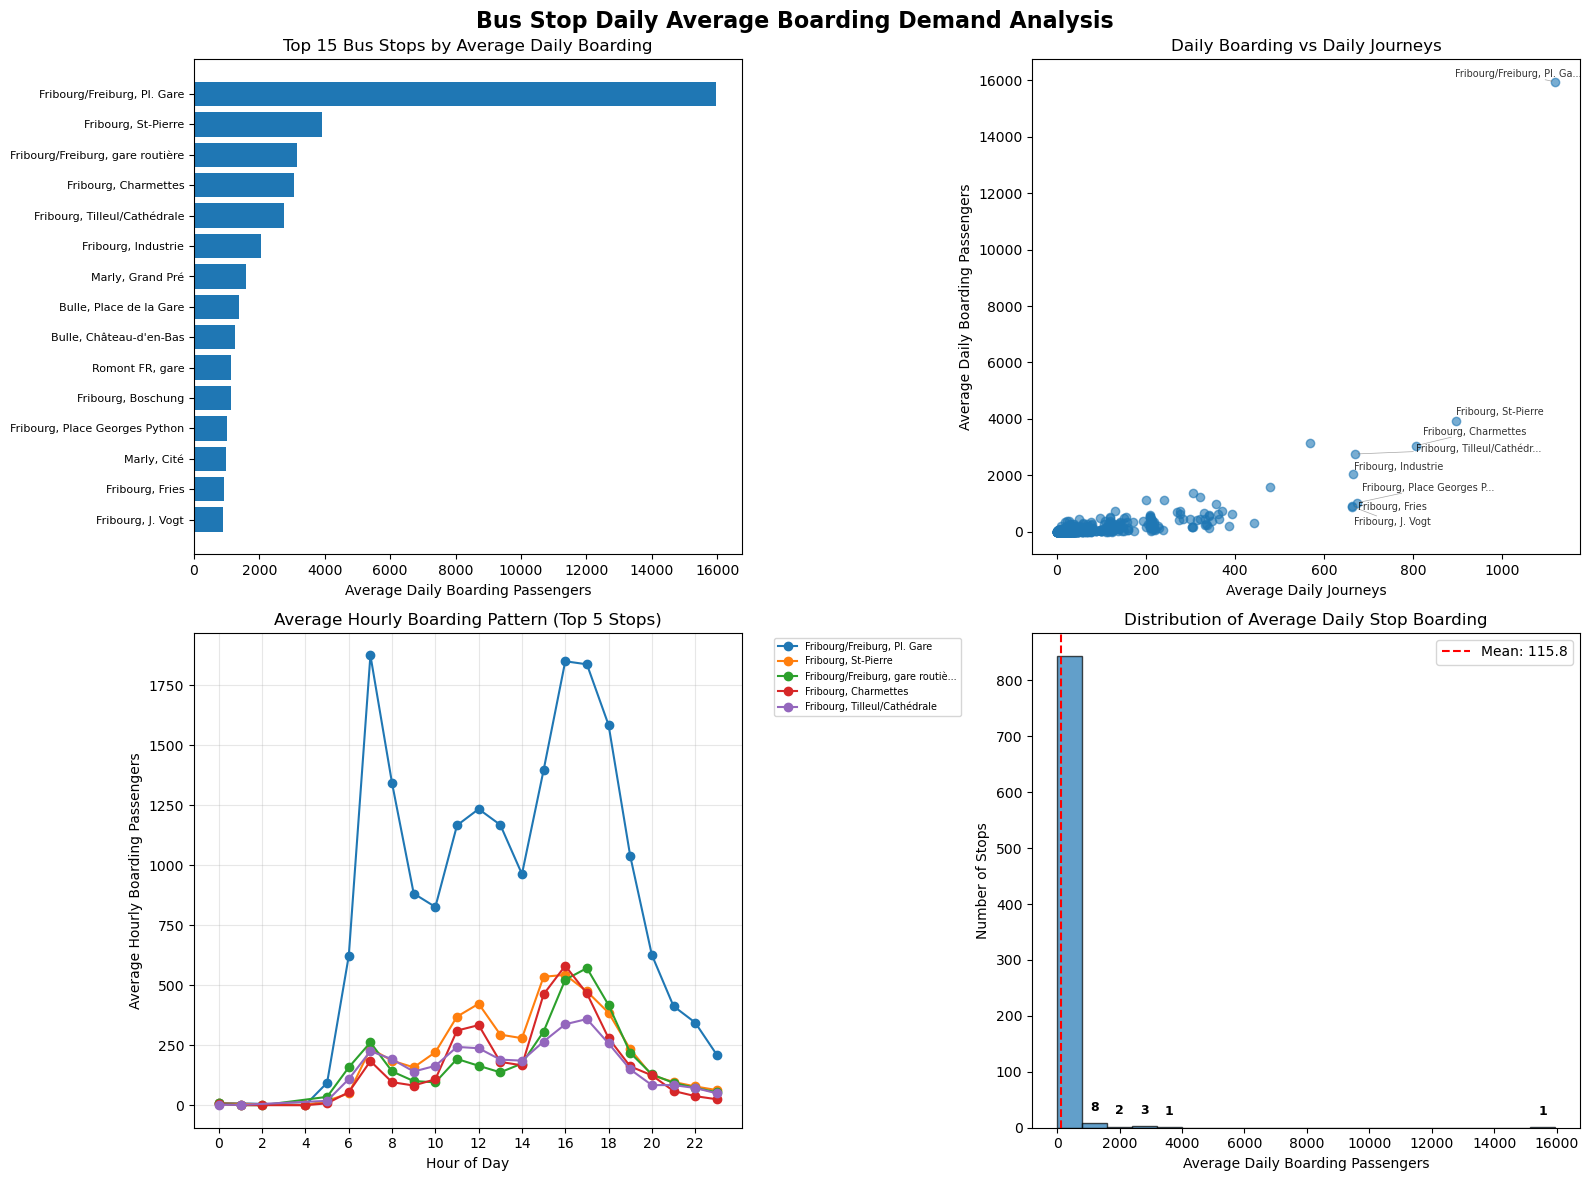


PEAK HOURS ANALYSIS FOR STOPS (AVERAGE DAILY BOARDING)

Top 3 Peak Hours (system-wide daily averages):
Hour 07:00 - 16042.3 average daily boardings
Hour 16:00 - 12718.4 average daily boardings
Hour 17:00 - 9796.0 average daily boardings

Peak hour for each of the top 10 busiest stops (by daily average):
Fribourg/Freiburg, Pl. Gare: Peak at 07:00 with 1875.5 avg daily boardings
Fribourg, St-Pierre: Peak at 16:00 with 543.5 avg daily boardings
Fribourg/Freiburg, gare routière: Peak at 17:00 with 571.7 avg daily boardings
Fribourg, Charmettes: Peak at 16:00 with 581.4 avg daily boardings
Fribourg, Tilleul/Cathédrale: Peak at 17:00 with 359.3 avg daily boardings
Fribourg, Industrie: Peak at 15:00 with 392.0 avg daily boardings
Marly, Grand Pré: Peak at 16:00 with 366.0 avg daily boardings
Bulle, Place de la Gare: Peak at 16:00 with 193.0 avg daily boardings
Bulle, Château-d'en-Bas: Peak at 16:00 with 422.8 avg daily boardings
Romont FR, gare: Peak at 16:00 with 285.3 avg daily boardings



In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

def analyze_bus_stop_demand(df):
    """
    Comprehensive analysis of bus stop demand - Average daily boarding passengers
    """
    
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    # Convert Arrival column to datetime if it's not already
    df_reset['Arrival'] = pd.to_datetime(df_reset['Arrival'])
    df_reset['Hour'] = df_reset['Arrival'].dt.hour
    df_reset['Date'] = df_reset['Arrival'].dt.date
    
    # 1. Basic demand analysis per stop - DAILY AVERAGES
    print("=" * 60)
    print("1. DAILY AVERAGE DEMAND ANALYSIS BY BUS STOP (BOARDING ONLY)")
    print("=" * 60)
    
    # Calculate total passengers getting on for each stop PER DAY, then average
    daily_stop_demand = df_reset.groupby(['StopName', 'Date']).agg({
        'On_Second_Class': 'sum',
        'Vehicle': 'nunique',  # Number of unique vehicles per day
        'Journey': 'nunique'   # Number of unique journeys per day
    })
    
    # Calculate average daily demand for each stop
    stop_demand = daily_stop_demand.groupby('StopName').agg({
        'On_Second_Class': 'mean',  # Average daily boarding
        'Vehicle': 'mean',          # Average unique vehicles per day
        'Journey': 'mean'           # Average unique journeys per day
    }).round(2)
    
    # Rename columns for clarity
    stop_demand.columns = ['Avg_Daily_Boarding', 'Avg_Daily_Vehicles', 'Avg_Daily_Journeys']
    
    # Add total days of operation for each stop
    days_per_stop = daily_stop_demand.groupby('StopName').size()
    stop_demand['Operating_Days'] = days_per_stop
    
    print(f"\nData period: {df_reset['Date'].min()} to {df_reset['Date'].max()}")
    print(f"Total unique days in dataset: {df_reset['Date'].nunique()}")
    print("\nSummary by Bus Stop - Average Daily Boarding (Top 20):")
    print(stop_demand.sort_values('Avg_Daily_Boarding', ascending=False).head(20))
    
    # 2a. Demand during the day (hourly analysis) - DAILY AVERAGES
    print("\n" + "=" * 60)
    print("2A. HOURLY BOARDING PATTERNS BY STOP (DAILY AVERAGES)")
    print("=" * 60)
    
    # Create hourly demand analysis - daily averages
    daily_hourly_demand = df_reset.groupby(['StopName', 'Date', 'Hour']).agg({
        'On_Second_Class': 'sum'
    })
    
    # Calculate average hourly demand across all days
    hourly_demand = daily_hourly_demand.groupby(['StopName', 'Hour']).agg({
        'On_Second_Class': 'mean'
    }).round(2)
    
    hourly_demand.columns = ['Avg_Hourly_Boarding']
    
    # Reset index for easier plotting
    hourly_demand_reset = hourly_demand.reset_index()
    
    print("\nSample of average hourly boarding demand (first few stops and hours):")
    print(hourly_demand.head(20))
    
    # 3. Rank bus stops based on average daily boarding demand
    print("\n" + "=" * 60)
    print("3. BUS STOP RANKING BY AVERAGE DAILY BOARDING DEMAND")
    print("=" * 60)
    
    # Create comprehensive ranking
    ranking_df = stop_demand.copy()
    ranking_df['Demand_Rank'] = ranking_df['Avg_Daily_Boarding'].rank(ascending=False)
    
    # Sort by average daily boarding (primary ranking metric)
    ranking_df = ranking_df.sort_values('Avg_Daily_Boarding', ascending=False)
    ranking_df['Overall_Rank'] = range(1, len(ranking_df) + 1)
    
    print("\nBus Stop Rankings by Average Daily Boarding (Top 20):")
    print(ranking_df[['Avg_Daily_Boarding', 'Avg_Daily_Vehicles', 'Avg_Daily_Journeys', 
                     'Operating_Days', 'Overall_Rank']].head(20))
    
    return stop_demand, hourly_demand_reset, ranking_df

def create_stop_visualizations(df, stop_demand, hourly_demand_reset, ranking_df):
    """
    Create visualizations for the stop daily average boarding demand analysis
    """
    
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Bus Stop Daily Average Boarding Demand Analysis', fontsize=16, fontweight='bold')
    
    # 1. Top 15 stops by average daily boarding
    top_stops = ranking_df.head(15)
    axes[0, 0].barh(range(len(top_stops)), top_stops['Avg_Daily_Boarding'])
    axes[0, 0].set_yticks(range(len(top_stops)))
    # Show full stop names
    axes[0, 0].set_yticklabels(top_stops.index, fontsize=8)
    axes[0, 0].set_xlabel('Average Daily Boarding Passengers')
    axes[0, 0].set_title('Top 15 Bus Stops by Average Daily Boarding')
    axes[0, 0].invert_yaxis()
    
    # 2. Average Daily Boarding vs Average Daily Journeys scatter plot
    axes[0, 1].scatter(ranking_df['Avg_Daily_Journeys'], ranking_df['Avg_Daily_Boarding'], alpha=0.6)
    axes[0, 1].set_xlabel('Average Daily Journeys')
    axes[0, 1].set_ylabel('Average Daily Boarding Passengers')
    axes[0, 1].set_title('Daily Boarding vs Daily Journeys')
    
    # Add text labels for stops with daily journeys > 600 and avoid overlap
    try:
        from adjustText import adjust_text
        texts = []
        for stop, row in ranking_df.iterrows():
            if row['Avg_Daily_Journeys'] > 600:
                # Truncate long stop names for readability
                stop_display = stop[:25] + '...' if len(stop) > 25 else stop
                text = axes[0, 1].annotate(stop_display, (row['Avg_Daily_Journeys'], row['Avg_Daily_Boarding']), 
                                          fontsize=7, alpha=0.8)
                texts.append(text)
        
        # Adjust text positions to avoid overlap
        if texts:
            adjust_text(texts, ax=axes[0, 1], 
                       arrowprops=dict(arrowstyle='->', color='gray', alpha=0.7, lw=0.5))
    except ImportError:
        # Fallback if adjustText is not available - use manual positioning
        for stop, row in ranking_df.iterrows():
            if row['Avg_Daily_Journeys'] > 600:
                stop_display = stop[:25] + '...' if len(stop) > 25 else stop
                axes[0, 1].annotate(stop_display, (row['Avg_Daily_Journeys'], row['Avg_Daily_Boarding']), 
                                  fontsize=7, alpha=0.8, 
                                  xytext=(5, 5), textcoords='offset points')
    
    # 3. Hourly boarding pattern for top 5 stops (daily averages)
    top_5_stops = ranking_df.head(5).index
    for stop in top_5_stops:
        stop_hourly = hourly_demand_reset[hourly_demand_reset['StopName'] == stop]
        if not stop_hourly.empty:
            # Truncate stop name for legend
            stop_display = stop[:30] + '...' if len(stop) > 30 else stop
            axes[1, 0].plot(stop_hourly['Hour'], stop_hourly['Avg_Hourly_Boarding'], 
                           marker='o', label=stop_display)
    
    axes[1, 0].set_xlabel('Hour of Day')
    axes[1, 0].set_ylabel('Average Hourly Boarding Passengers')
    axes[1, 0].set_title('Average Hourly Boarding Pattern (Top 5 Stops)')
    axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xticks(range(0, 24, 2))
    
    # 4. Distribution of average daily stop boarding demands
    n, bins, patches = axes[1, 1].hist(ranking_df['Avg_Daily_Boarding'], bins=20, edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Average Daily Boarding Passengers')
    axes[1, 1].set_ylabel('Number of Stops')
    axes[1, 1].set_title('Distribution of Average Daily Stop Boarding')
    axes[1, 1].axvline(ranking_df['Avg_Daily_Boarding'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {ranking_df["Avg_Daily_Boarding"].mean():.1f}')
    
    # Add text above bars for high-demand bins
    high_demand_threshold = ranking_df['Avg_Daily_Boarding'].quantile(0.8)  # Top 20%
    for i, (count, left_edge, right_edge) in enumerate(zip(n, bins[:-1], bins[1:])):
        if left_edge > high_demand_threshold and count > 0:
            # Position text at the center of the bin, above the bar
            x_pos = (left_edge + right_edge) / 2
            y_pos = count + max(n) * 0.02  # Slightly above the bar
            axes[1, 1].text(x_pos, y_pos, f'{int(count)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

def generate_stop_peak_hours_analysis(df):
    """
    Additional analysis for peak hours at stops (average daily boarding only)
    """
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    df_reset['Hour'] = pd.to_datetime(df_reset['Arrival']).dt.hour
    df_reset['Date'] = pd.to_datetime(df_reset['Arrival']).dt.date
    
    # Calculate daily hourly totals, then average
    daily_hourly_total = df_reset.groupby(['Date', 'Hour'])['On_Second_Class'].sum()
    hourly_average = daily_hourly_total.groupby('Hour').mean()
    peak_hours = hourly_average.nlargest(3)
    
    print("\n" + "=" * 60)
    print("PEAK HOURS ANALYSIS FOR STOPS (AVERAGE DAILY BOARDING)")
    print("=" * 60)
    print(f"\nTop 3 Peak Hours (system-wide daily averages):")
    for hour, demand in peak_hours.items():
        print(f"Hour {hour:02d}:00 - {demand:.1f} average daily boardings")
    
    # Peak hours by stop (for top 10 stops by daily average)
    daily_stop_totals = df_reset.groupby(['StopName', 'Date'])['On_Second_Class'].sum()
    avg_daily_by_stop = daily_stop_totals.groupby('StopName').mean()
    top_10_stops = avg_daily_by_stop.nlargest(10).index
    
    print(f"\nPeak hour for each of the top 10 busiest stops (by daily average):")
    for stop in top_10_stops:
        stop_data = df_reset[df_reset['StopName'] == stop]
        # Calculate daily hourly averages for this stop
        daily_stop_hourly = stop_data.groupby(['Date', 'Hour'])['On_Second_Class'].sum()
        stop_hourly_avg = daily_stop_hourly.groupby('Hour').mean()
        
        if not stop_hourly_avg.empty:
            peak_hour = stop_hourly_avg.idxmax()
            peak_demand = stop_hourly_avg.max()
            stop_display = stop[:40] + '...' if len(stop) > 40 else stop
            print(f"{stop_display}: Peak at {peak_hour:02d}:00 with {peak_demand:.1f} avg daily boardings")

def quick_stop_summary(df):
    """
    Quick summary statistics for stops (daily averages for boarding only)
    """
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    df_reset['Date'] = pd.to_datetime(df_reset['Arrival']).dt.date
    total_days = df_reset['Date'].nunique()
    total_boardings = df_reset['On_Second_Class'].sum()
    
    print("\nQUICK SUMMARY FOR STOPS (DAILY AVERAGES - BOARDING ONLY)")
    print("=" * 50)
    print(f"Total unique bus stops: {df_reset['StopName'].nunique()}")
    print(f"Total unique vehicles: {df_reset['Vehicle'].nunique()}")
    print(f"Total days in dataset: {total_days}")
    print(f"Total passenger boardings: {total_boardings:,.0f}")
    print(f"Average daily boardings (system-wide): {total_boardings/total_days:,.0f}")
    print(f"Average boardings per record: {df_reset['On_Second_Class'].mean():.2f}")
    print(f"Date range: {df_reset['Date'].min()} to {df_reset['Date'].max()}")

# Run the main analysis
print("Analyzing bus stop demand using DAILY AVERAGES...")
stop_demand, hourly_demand, ranking = analyze_bus_stop_demand(plcs_with_on_off)

# Create visualizations
create_stop_visualizations(plcs_with_on_off, stop_demand, hourly_demand, ranking)

# Generate peak hours analysis
generate_stop_peak_hours_analysis(plcs_with_on_off)

# Get quick summary
quick_stop_summary(plcs_with_on_off)

# Delay Hourly distribution

Selected lines delay statistics:
      Avg_Delay_Seconds  Std_Delay_Seconds  Total_Records
Line                                                     
2.0              132.60             155.17         106449
1.0              108.46             119.56          99211
3.0               95.87             130.02          43682
5.0               72.45              99.10         113250
7.0               64.37             130.33          45543




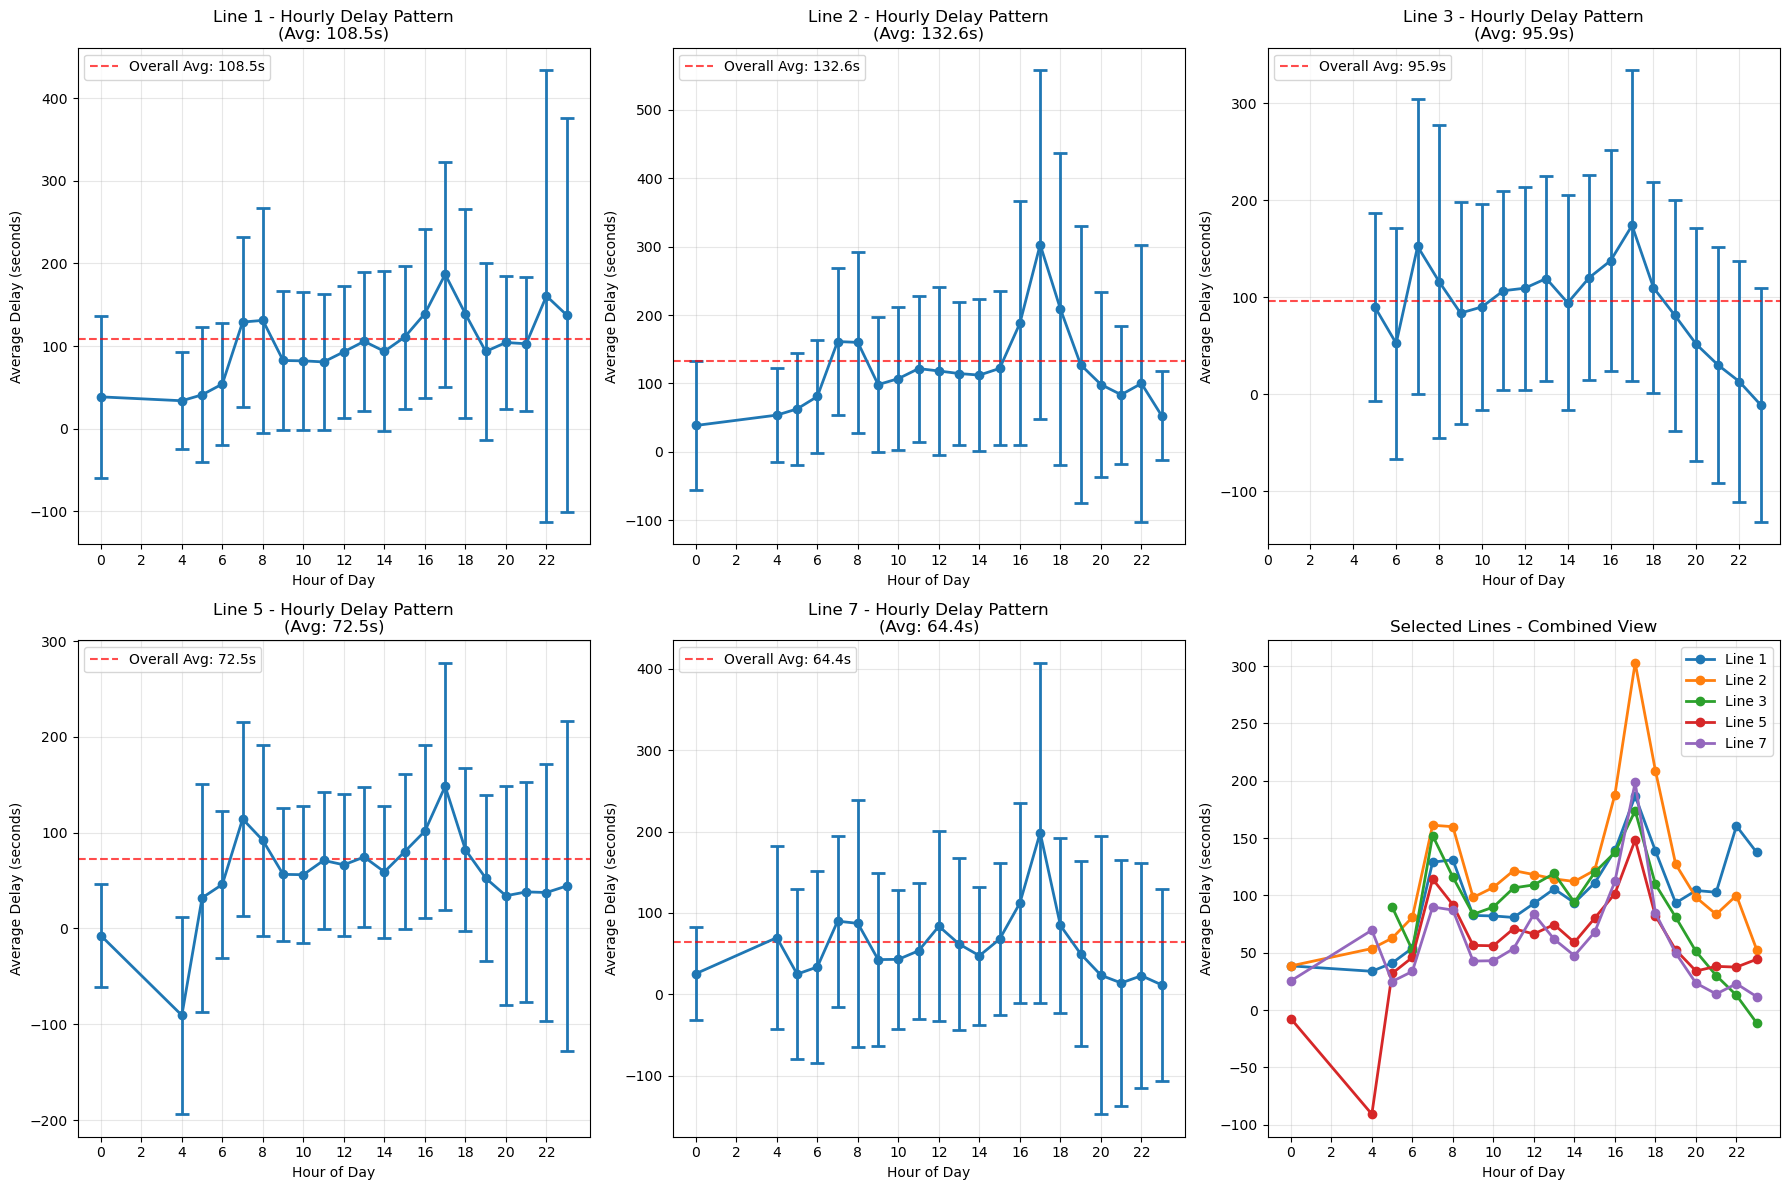

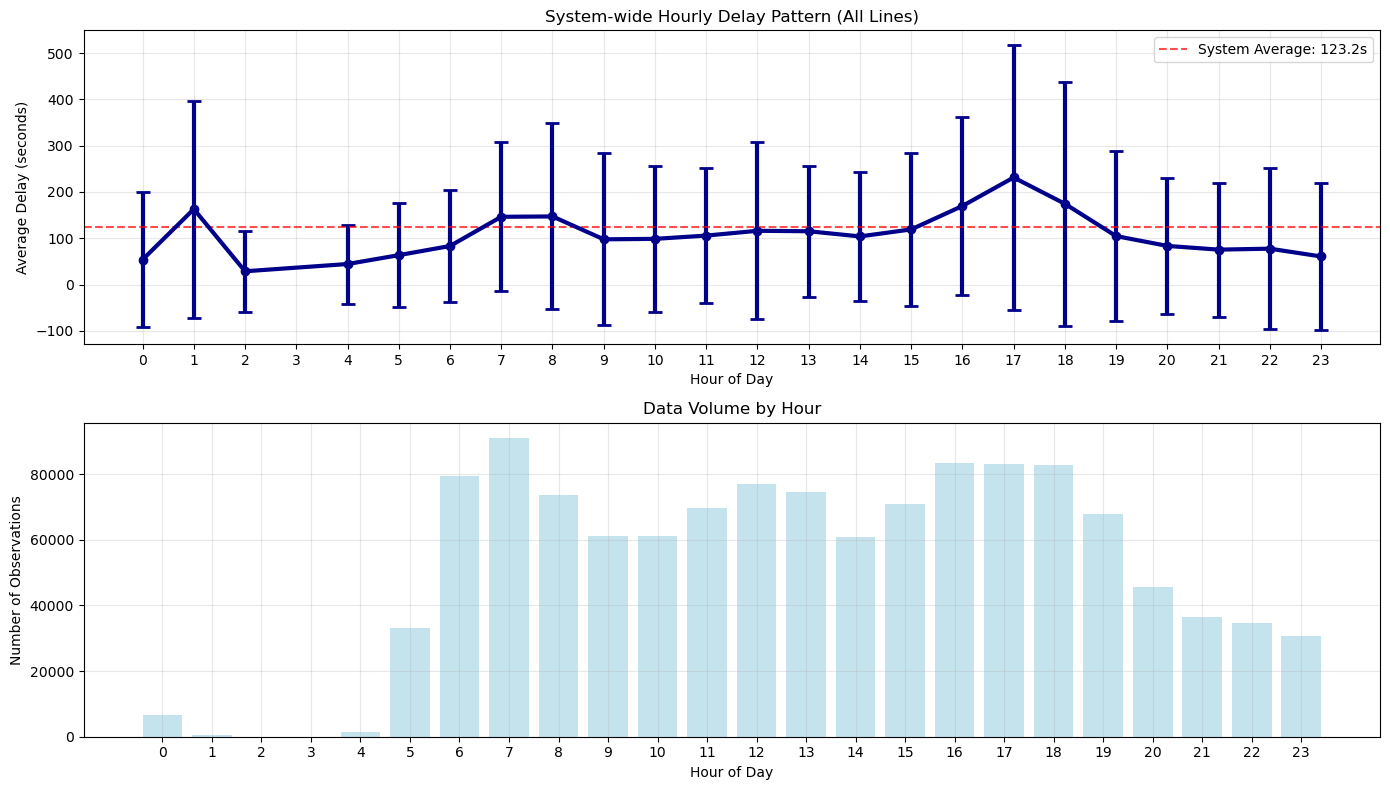

DELAY ANALYSIS SUMMARY
System-wide average delay: 123.23 seconds
Peak delay hour: 17:00 (231.18s)
Best performance hour: 2:00 (28.64s)


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_hourly_delays(plcs_with_on_off, selected_lines):
    """
    Plot hourly delay patterns for selected bus lines
    
    Parameters:
    plcs_with_on_off: DataFrame with bus data
    selected_lines: List of line numbers to analyze (e.g., [201, 336, 412])
    """
    
    # Calculate average delay by line
    line_delays = plcs_with_on_off.groupby('Line').agg({
        'Punctuality_Seconds': ['mean', 'std', 'count']
    }).round(2)
    
    # Flatten column names
    line_delays.columns = ['Avg_Delay_Seconds', 'Std_Delay_Seconds', 'Total_Records']
    
    # Filter for selected lines only
    available_lines = [line for line in selected_lines if line in line_delays.index]
    if len(available_lines) != len(selected_lines):
        missing_lines = [line for line in selected_lines if line not in line_delays.index]
        print(f"Warning: Lines {missing_lines} not found in data. Available lines will be analyzed.")
    
    selected_delay_lines = line_delays.loc[available_lines]
    print(f"Selected lines delay statistics:")
    print(selected_delay_lines.sort_values('Avg_Delay_Seconds', ascending=False))
    print("\n" + "="*50 + "\n")
    
    # Get the line numbers for plotting
    top_lines = available_lines
    
    # Calculate hourly delays for these top lines
    hourly_delays = plcs_with_on_off[plcs_with_on_off['Line'].isin(top_lines)].groupby(['Line', 'Hour']).agg({
        'Punctuality_Seconds': ['mean', 'std', 'count']
    }).reset_index()
    
    # Flatten column names
    hourly_delays.columns = ['Line', 'Hour', 'Avg_Delay', 'Std_Delay', 'Count']
    
    # Create subplots for individual lines
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, line in enumerate(top_lines):
        if i >= len(axes) - 1:  # Reserve last subplot for combined view
            break
            
        line_hourly = hourly_delays[hourly_delays['Line'] == line]
        
        # Plot average delay with error bars (standard deviation)
        axes[i].errorbar(line_hourly['Hour'], line_hourly['Avg_Delay'], 
                        yerr=line_hourly['Std_Delay'], 
                        marker='o', linewidth=2, capsize=5, capthick=2)
        
        axes[i].set_xlabel('Hour of Day')
        axes[i].set_ylabel('Average Delay (seconds)')
        axes[i].set_title(f'Line {int(line)} - Hourly Delay Pattern\n(Avg: {selected_delay_lines.loc[line, "Avg_Delay_Seconds"]:.1f}s)')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xticks(range(0, 24, 2))
        
        # Add horizontal line for overall average
        axes[i].axhline(y=selected_delay_lines.loc[line, 'Avg_Delay_Seconds'], 
                       color='red', linestyle='--', alpha=0.7, 
                       label=f'Overall Avg: {selected_delay_lines.loc[line, "Avg_Delay_Seconds"]:.1f}s')
        axes[i].legend()
    
    # Combined view in the last subplot
    axes[-1].set_title('Selected Lines - Combined View')
    for line in top_lines:
        line_hourly = hourly_delays[hourly_delays['Line'] == line]
        axes[-1].plot(line_hourly['Hour'], line_hourly['Avg_Delay'], 
                     marker='o', linewidth=2, label=f'Line {int(line)}')
    
    axes[-1].set_xlabel('Hour of Day')
    axes[-1].set_ylabel('Average Delay (seconds)')
    axes[-1].grid(True, alpha=0.3)
    axes[-1].set_xticks(range(0, 24, 2))
    axes[-1].legend()
    
    # Hide any unused subplots
    for j in range(len(top_lines) + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # System-wide hourly delay pattern
    plt.figure(figsize=(14, 8))
    
    # Overall hourly delays across all lines
    system_hourly = plcs_with_on_off.groupby('Hour').agg({
        'Punctuality_Seconds': ['mean', 'std', 'count']
    })
    system_hourly.columns = ['Avg_Delay', 'Std_Delay', 'Count']
    
    # Plot system-wide pattern
    plt.subplot(2, 1, 1)
    plt.errorbar(system_hourly.index, system_hourly['Avg_Delay'], 
                yerr=system_hourly['Std_Delay'], 
                marker='o', linewidth=3, capsize=5, capthick=2, color='darkblue')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Delay (seconds)')
    plt.title('System-wide Hourly Delay Pattern (All Lines)')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, 24))
    
    # Add overall system average line
    overall_avg = plcs_with_on_off['Punctuality_Seconds'].mean()
    plt.axhline(y=overall_avg, color='red', linestyle='--', alpha=0.7, 
               label=f'System Average: {overall_avg:.1f}s')
    plt.legend()
    
    # Plot number of observations per hour
    plt.subplot(2, 1, 2)
    plt.bar(system_hourly.index, system_hourly['Count'], alpha=0.7, color='lightblue')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Observations')
    plt.title('Data Volume by Hour')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, 24))
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("DELAY ANALYSIS SUMMARY")
    print("="*50)
    print(f"System-wide average delay: {overall_avg:.2f} seconds")
    print(f"Peak delay hour: {system_hourly['Avg_Delay'].idxmax()}:00 ({system_hourly['Avg_Delay'].max():.2f}s)")
    print(f"Best performance hour: {system_hourly['Avg_Delay'].idxmin()}:00 ({system_hourly['Avg_Delay'].min():.2f}s)")
    
    return hourly_delays, selected_delay_lines, system_hourly

# Example usage:
# Select specific lines to analyze
selected_lines = [1,2,3,5,7]  # Choose any lines you want
hourly_data, selected_stats, system_data = plot_hourly_delays(plcs_with_on_off, selected_lines)

Delay impact hourly distribution

Selected lines delay impact statistics:
      Avg_Delay_Impact  Total_Delay_Impact  Std_Delay_Impact  Total_Records  \
Line                                                                          
2.0            4350.89        4.631481e+08           9659.14         106449   
1.0            3596.76        3.568385e+08           7529.68          99211   
3.0            2049.75        8.953735e+07           4378.04          43682   
5.0            1682.26        1.905163e+08           3863.03         113250   
7.0            1284.02        5.847796e+07           3566.13          45543   

      Avg_Delay_Seconds  Avg_Passengers  
Line                                     
2.0              132.60           27.26  
1.0              108.46           27.39  
3.0               95.87           16.18  
5.0               72.45           16.63  
7.0               64.37           13.14  




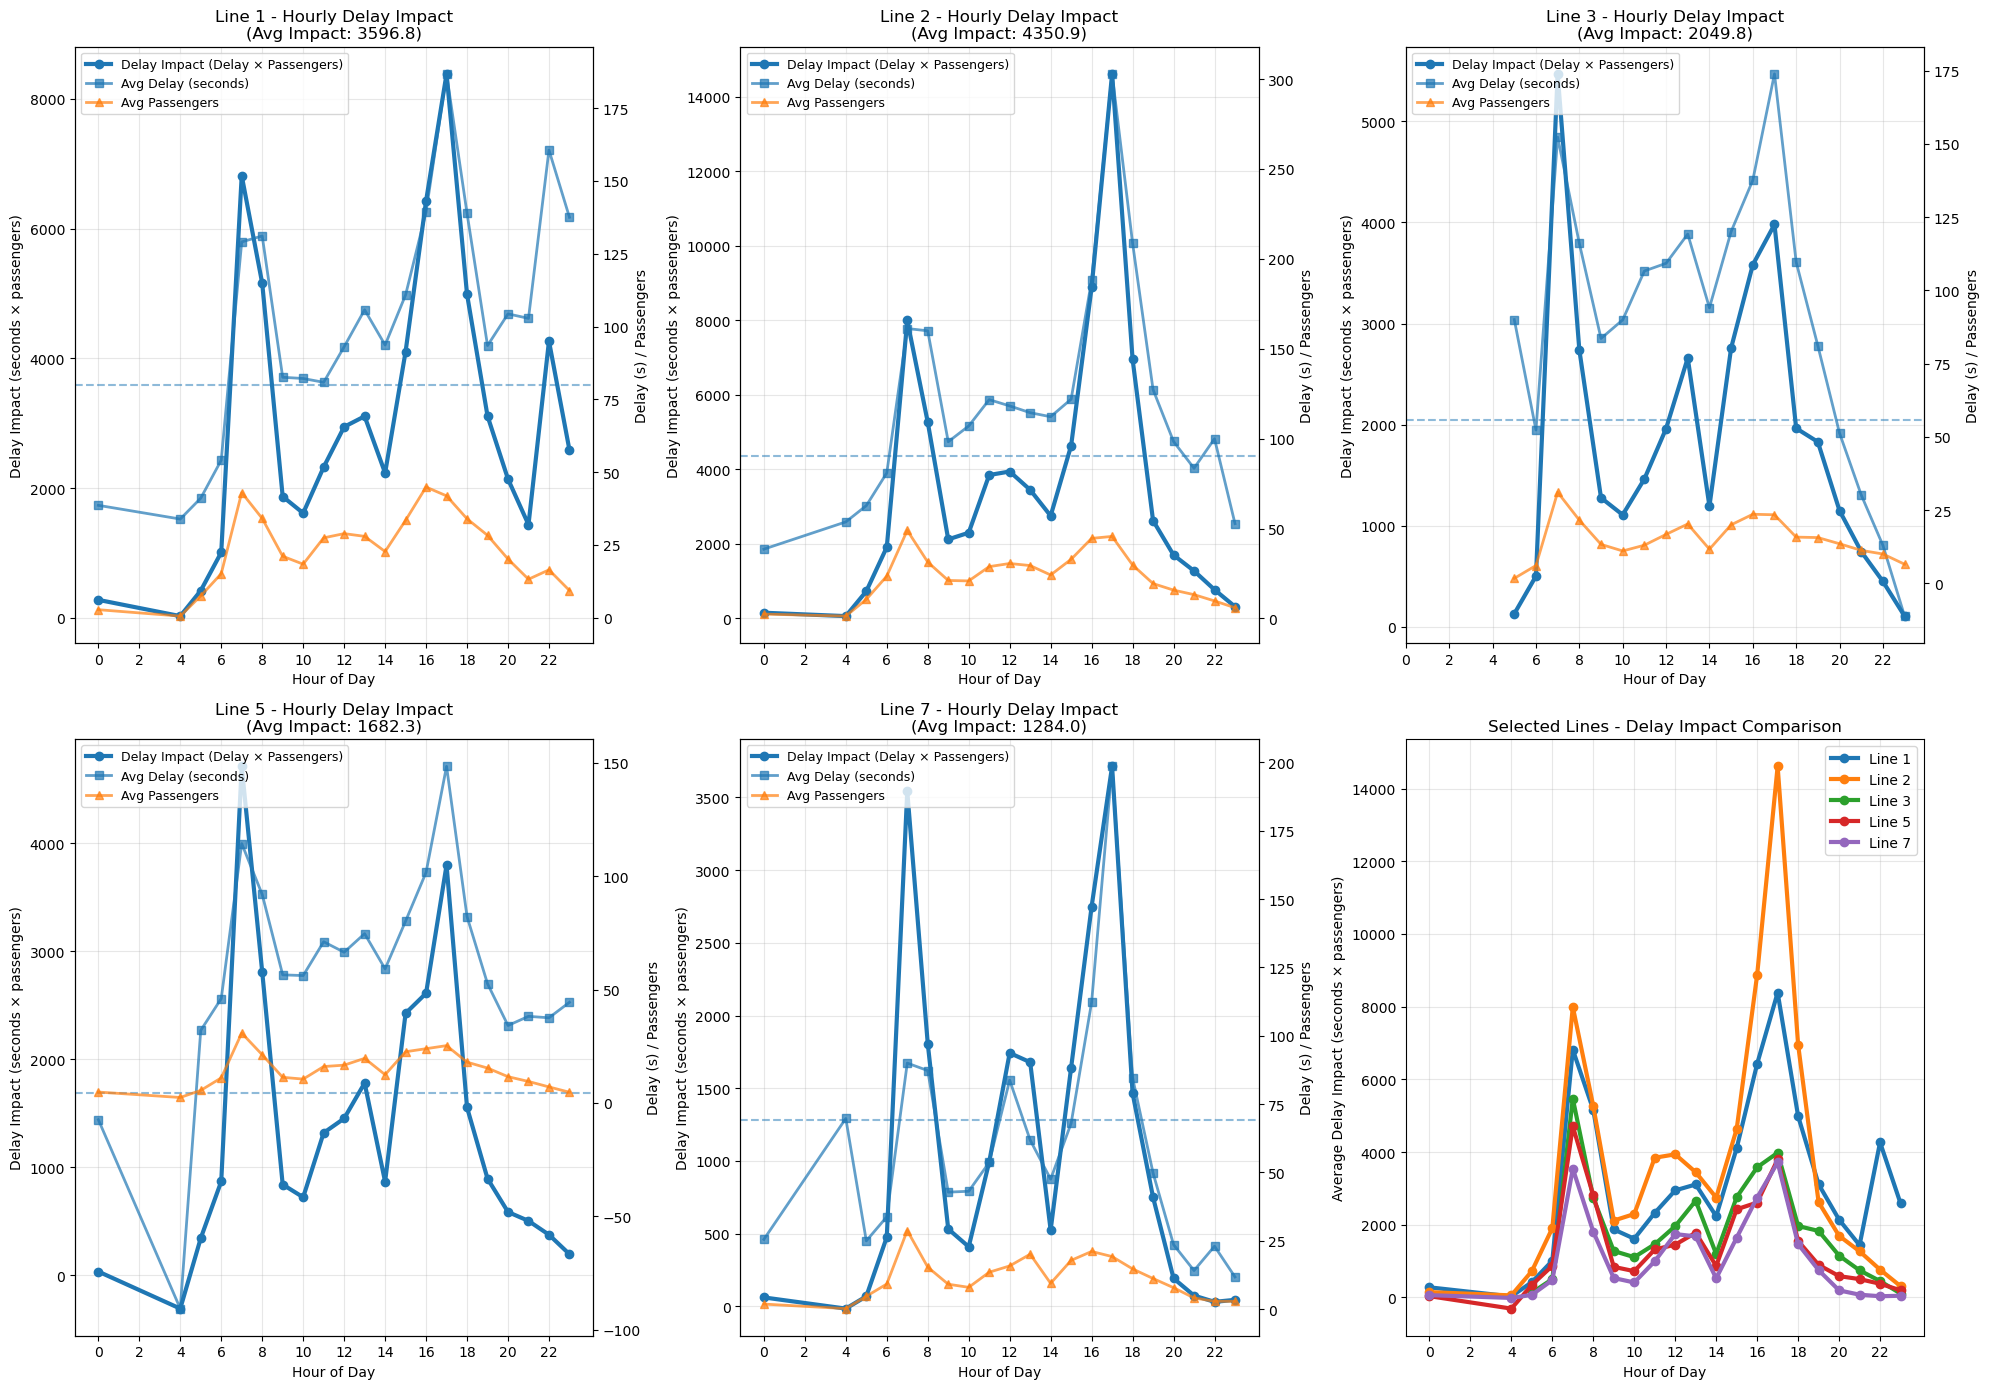

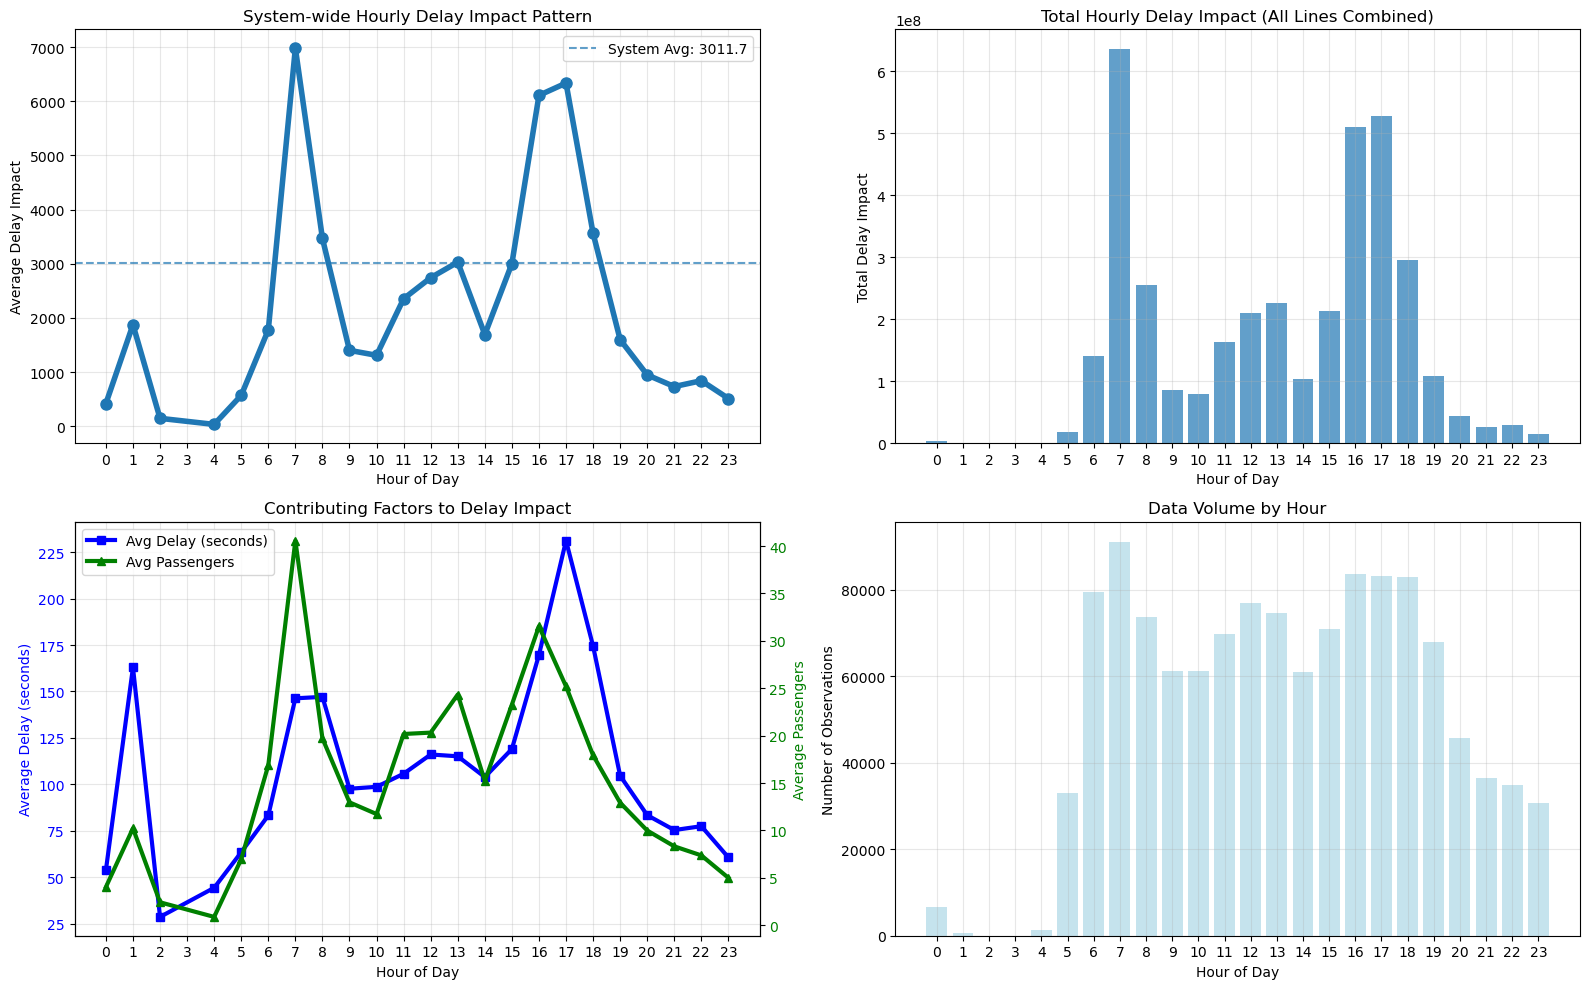

DELAY IMPACT ANALYSIS SUMMARY
System-wide average delay impact: 3011.70 (seconds × passengers)
Peak impact hour: 7:00 (6981.21)
Lowest impact hour: 4:00 (32.52)
Total daily delay impact: 3,694,057,602

Peak hour (7:00) breakdown:
  - Average delay: 146.3 seconds
  - Average passengers: 40.6
  - Delay impact: 6981.2


In [17]:

def plot_hourly_delay_impact(plcs_with_on_off, selected_lines):
    """
    Plot hourly delay impact patterns (delay × passengers) for selected bus lines
    
    Parameters:
    plcs_with_on_off: DataFrame with bus data
    selected_lines: List of line numbers to analyze (e.g., [201, 336, 412])
    """
    
    # Calculate delay impact (delay * passengers on bus)
    plcs_with_on_off['Delay_Impact'] = plcs_with_on_off['Punctuality_Seconds'] * plcs_with_on_off['Passenger_Count']
    
    # Calculate statistics by line
    line_impact = plcs_with_on_off.groupby('Line').agg({
        'Delay_Impact': ['mean', 'sum', 'std', 'count'],
        'Punctuality_Seconds': 'mean',
        'Passenger_Count': 'mean'
    }).round(2)
    
    # Flatten column names
    line_impact.columns = ['Avg_Delay_Impact', 'Total_Delay_Impact', 'Std_Delay_Impact', 'Total_Records',
                          'Avg_Delay_Seconds', 'Avg_Passengers']
    
    # Filter for selected lines only
    available_lines = [line for line in selected_lines if line in line_impact.index]
    if len(available_lines) != len(selected_lines):
        missing_lines = [line for line in selected_lines if line not in line_impact.index]
        print(f"Warning: Lines {missing_lines} not found in data. Available lines will be analyzed.")
    
    selected_impact_lines = line_impact.loc[available_lines]
    print(f"Selected lines delay impact statistics:")
    print(selected_impact_lines.sort_values('Avg_Delay_Impact', ascending=False))
    print("\n" + "="*60 + "\n")
    
    # Calculate hourly delay impact for these selected lines
    hourly_impact = plcs_with_on_off[plcs_with_on_off['Line'].isin(available_lines)].groupby(['Line', 'Hour']).agg({
        'Delay_Impact': ['mean', 'sum', 'std', 'count'],
        'Punctuality_Seconds': 'mean',
        'Passenger_Count': 'mean'
    }).reset_index()
    
    # Flatten column names
    hourly_impact.columns = ['Line', 'Hour', 'Avg_Delay_Impact', 'Total_Delay_Impact', 'Std_Delay_Impact', 'Count',
                           'Avg_Delay', 'Avg_Passengers']
    
    # Create subplots for individual lines
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    axes = axes.flatten()
    
    for i, line in enumerate(available_lines):
        if i >= len(axes) - 1:  # Reserve last subplot for combined view
            break
            
        line_hourly = hourly_impact[hourly_impact['Line'] == line]
        
        # Create dual y-axis plot
        ax1 = axes[i]
        ax2 = ax1.twinx()
        
        # Plot delay impact (primary y-axis)
        line1 = ax1.plot(line_hourly['Hour'], line_hourly['Avg_Delay_Impact'], 
                        marker='o', linewidth=3, markersize=6,
                        label='Delay Impact (Delay × Passengers)')
        
        # Plot average delay and passengers (secondary y-axis)
        line2 = ax2.plot(line_hourly['Hour'], line_hourly['Avg_Delay'], 
                        marker='s', linewidth=2, alpha=0.7,
                        label='Avg Delay (seconds)')
        line3 = ax2.plot(line_hourly['Hour'], line_hourly['Avg_Passengers'], 
                        marker='^', linewidth=2, alpha=0.7,
                        label='Avg Passengers')
        
        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('Delay Impact (seconds × passengers)')
        ax2.set_ylabel('Delay (s) / Passengers')
        ax1.set_title(f'Line {int(line)} - Hourly Delay Impact\n(Avg Impact: {selected_impact_lines.loc[line, "Avg_Delay_Impact"]:.1f})')
        ax1.grid(True, alpha=0.3)
        ax1.set_xticks(range(0, 24, 2))
        
        # Add legends
        lines1 = line1
        lines2 = line2 + line3
        labels1 = [l.get_label() for l in lines1]
        labels2 = [l.get_label() for l in lines2]
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)
        
        # Add horizontal line for overall average impact
        ax1.axhline(y=selected_impact_lines.loc[line, 'Avg_Delay_Impact'], 
                   linestyle='--', alpha=0.5)
    
    # Combined view in the last subplot - Delay Impact only
    if len(available_lines) <= len(axes) - 1:
        axes[-1].set_title('Selected Lines - Delay Impact Comparison')
        for line in available_lines:
            line_hourly = hourly_impact[hourly_impact['Line'] == line]
            axes[-1].plot(line_hourly['Hour'], line_hourly['Avg_Delay_Impact'], 
                         marker='o', linewidth=3, markersize=6, label=f'Line {int(line)}')
        
        axes[-1].set_xlabel('Hour of Day')
        axes[-1].set_ylabel('Average Delay Impact (seconds × passengers)')
        axes[-1].grid(True, alpha=0.3)
        axes[-1].set_xticks(range(0, 24, 2))
        axes[-1].legend()
    
    # Hide any unused subplots
    for j in range(len(available_lines) + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # System-wide hourly delay impact pattern
    plt.figure(figsize=(16, 10))
    
    # Overall hourly delay impact across all lines
    system_hourly = plcs_with_on_off.groupby('Hour').agg({
        'Delay_Impact': ['mean', 'sum', 'std', 'count'],
        'Punctuality_Seconds': 'mean',
        'Passenger_Count': 'mean'
    })
    system_hourly.columns = ['Avg_Delay_Impact', 'Total_Delay_Impact', 'Std_Delay_Impact', 'Count',
                           'Avg_Delay', 'Avg_Passengers']
    
    # Plot 1: System-wide delay impact
    plt.subplot(2, 2, 1)
    plt.plot(system_hourly.index, system_hourly['Avg_Delay_Impact'], 
            marker='o', linewidth=4, markersize=8)
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Delay Impact')
    plt.title('System-wide Hourly Delay Impact Pattern')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, 24))
    
    # Add overall system average line
    overall_avg_impact = plcs_with_on_off['Delay_Impact'].mean()
    plt.axhline(y=overall_avg_impact, linestyle='--', alpha=0.7, 
               label=f'System Avg: {overall_avg_impact:.1f}')
    plt.legend()
    
    # Plot 2: Total delay impact (cumulative effect)
    plt.subplot(2, 2, 2)
    plt.bar(system_hourly.index, system_hourly['Total_Delay_Impact'], 
           alpha=0.7)
    plt.xlabel('Hour of Day')
    plt.ylabel('Total Delay Impact')
    plt.title('Total Hourly Delay Impact (All Lines Combined)')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, 24))
    
    # Plot 3: Contributing factors
    plt.subplot(2, 2, 3)
    ax3 = plt.gca()
    ax4 = ax3.twinx()
    
    line1 = ax3.plot(system_hourly.index, system_hourly['Avg_Delay'], 
                    color='blue', marker='s', linewidth=3, label='Avg Delay (seconds)')
    line2 = ax4.plot(system_hourly.index, system_hourly['Avg_Passengers'], 
                    color='green', marker='^', linewidth=3, label='Avg Passengers')
    
    ax3.set_xlabel('Hour of Day')
    ax3.set_ylabel('Average Delay (seconds)', color='blue')
    ax4.set_ylabel('Average Passengers', color='green')
    ax3.set_title('Contributing Factors to Delay Impact')
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(range(0, 24))
    
    ax3.tick_params(axis='y', labelcolor='blue')
    ax4.tick_params(axis='y', labelcolor='green')
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax3.legend(lines, labels, loc='upper left')
    
    # Plot 4: Data volume
    plt.subplot(2, 2, 4)
    plt.bar(system_hourly.index, system_hourly['Count'], alpha=0.7, color='lightblue')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Observations')
    plt.title('Data Volume by Hour')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, 24))
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("DELAY IMPACT ANALYSIS SUMMARY")
    print("="*60)
    print(f"System-wide average delay impact: {overall_avg_impact:.2f} (seconds × passengers)")
    print(f"Peak impact hour: {system_hourly['Avg_Delay_Impact'].idxmax()}:00 ({system_hourly['Avg_Delay_Impact'].max():.2f})")
    print(f"Lowest impact hour: {system_hourly['Avg_Delay_Impact'].idxmin()}:00 ({system_hourly['Avg_Delay_Impact'].min():.2f})")
    print(f"Total daily delay impact: {system_hourly['Total_Delay_Impact'].sum():,.0f}")
    
    # Peak impact analysis
    peak_hour = system_hourly['Avg_Delay_Impact'].idxmax()
    peak_stats = system_hourly.loc[peak_hour]
    print(f"\nPeak hour ({peak_hour}:00) breakdown:")
    print(f"  - Average delay: {peak_stats['Avg_Delay']:.1f} seconds")
    print(f"  - Average passengers: {peak_stats['Avg_Passengers']:.1f}")
    print(f"  - Delay impact: {peak_stats['Avg_Delay_Impact']:.1f}")
    
    return hourly_impact, selected_impact_lines, system_hourly

# Example usage:
# Select specific lines to analyze delay impact
selected_lines = [1, 2, 3, 5, 7]  # Choose any lines you want
impact_data, selected_stats, system_data = plot_hourly_delay_impact(plcs_with_on_off, selected_lines)

# Delay Analysis

## Stop Delay

### Delay Sum

In [18]:
import pandas as pd
import numpy as np

def analyze_top_delays_weighted(df, n_stops=5, m_lines=3, min_occurrences=100):
    """
    Find top delay stations and lines by total delay impact
    Impact = sum of (delay × passenger_count) - shows total passenger-time lost
    Aggregates by Didok (station) instead of individual Stop IDs
    """
    
    # Reset index if needed
    if df.index.name == 'Vehicle':
        df = df.reset_index()
    
    # Filter stops with enough data (by Didok)
    didok_counts = df['Didok'].value_counts()
    frequent_didoks = didok_counts[didok_counts > min_occurrences].index
    df_filtered = df[df['Didok'].isin(frequent_didoks)]
    
    print(f"Analyzing {len(frequent_didoks)} stations (Didok) with > {min_occurrences} records")
    
    # Calculate weighted median for each Didok station
    didok_results = []
    for didok_id in frequent_didoks:
        didok_data = df_filtered[df_filtered['Didok'] == didok_id]
        
        # Calculate delay impact (delay * passengers)
        delays = didok_data['Punctuality_Seconds']
        passengers = didok_data['Passenger_Count']
        
        # Total delay impact = sum of (delay * passengers)
        delay_impact = (delays * passengers).sum()
        
        didok_results.append({
            'Didok': didok_id,
            'StationName': didok_data['StopName'].iloc[0],  # Use first stop name as station name
            'Delay_Impact': delay_impact,
            'Total_Passengers': passengers.sum()
        })
    
    # Get top delay impact stations
    didok_df = pd.DataFrame(didok_results)
    top_stations = didok_df.nlargest(n_stops, 'Delay_Impact')
    
    print(f"\nTop {n_stops} stations by delay impact (delay × passengers):")
    for _, row in top_stations.iterrows():
        print(f"{int(row['Didok'])}: {row['StationName']} - {row['Delay_Impact']:.0f} passenger-seconds")
    
    # For each top station, find worst lines
    print(f"\nTop {m_lines} lines at each station:")
    for _, station_row in top_stations.iterrows():
        station_data = df[df['Didok'] == station_row['Didok']]
        
        line_results = []
        for line_id in station_data['Line'].unique():
            line_data = station_data[station_data['Line'] == line_id]
            delays = line_data['Punctuality_Seconds']
            passengers = line_data['Passenger_Count']
            delay_impact = (delays * passengers).sum()
            
            line_results.append({
                'Line': line_id,
                'Delay_Impact': delay_impact
            })
        
        line_df = pd.DataFrame(line_results)
        top_lines = line_df.nlargest(m_lines, 'Delay_Impact')
        
        print(f"\n{station_row['StationName']}:")
        for _, line_row in top_lines.iterrows():
            print(f"  Line {int(line_row['Line'])}: {line_row['Delay_Impact']:.0f} passenger-seconds")

# Usage:
analyze_top_delays_weighted(plcs_with_on_off, n_stops=10, m_lines=5, min_occurrences=100)

Analyzing 799 stations (Didok) with > 100 records

Top 10 stations by delay impact (delay × passengers):
8592374: Fribourg/Freiburg, Pl. Gare - 88214764 passenger-seconds
8589161: Fribourg, St-Pierre - 73867277 passenger-seconds
8588858: Fribourg, J. Vogt - 72812709 passenger-seconds
8587255: Fribourg, Tilleul/Cathédrale - 72615233 passenger-seconds
8589155: Fribourg, Fries - 69341174 passenger-seconds
8587356: Fribourg, Pont-Zaehringen - 66089324 passenger-seconds
8589154: Fribourg, Industrie - 60912824 passenger-seconds
8577810: Fribourg, Place Georges Python - 60777420 passenger-seconds
8589162: Fribourg, Stadtberg - 60167742 passenger-seconds
8577784: Fribourg, Beauregard - 55061001 passenger-seconds

Top 5 lines at each station:

Fribourg/Freiburg, Pl. Gare:
  Line 2: 25645838 passenger-seconds
  Line 1: 20567037 passenger-seconds
  Line 6: 15050914 passenger-seconds
  Line 8: 9733208 passenger-seconds
  Line 5: 6024873 passenger-seconds

Fribourg, St-Pierre:
  Line 2: 26466653 pa

### Delay Average

In [19]:
import pandas as pd
import numpy as np

def analyze_top_delays_weighted(df, n_stops=5, m_lines=3, min_occurrences=100):
    """
    Find top delay stops and lines weighted by passenger count
    Aggregates by Didok (station) instead of individual Stop IDs
    """
    
    # Reset index if needed
    if df.index.name == 'Vehicle':
        df = df.reset_index()
    
    # Filter stops with enough data (by Didok)
    didok_counts = df['Didok'].value_counts()
    frequent_didoks = didok_counts[didok_counts > min_occurrences].index
    df_filtered = df[df['Didok'].isin(frequent_didoks)]
    
    print(f"Analyzing {len(frequent_didoks)} stations (Didok) with > {min_occurrences} records")
    
    # Calculate weighted median for each Didok station
    didok_results = []
    for didok_id in frequent_didoks:
        didok_data = df_filtered[df_filtered['Didok'] == didok_id]
        
        # Weight delays by passenger count
        delays = didok_data['Punctuality_Seconds']
        passengers = didok_data['Passenger_Count']
        
        # Weight delays by passenger count - sum of (delay * passengers)
        weighted_delay_sum = (delays * passengers).sum()
        total_passengers = passengers.sum()
        weighted_delay = weighted_delay_sum / total_passengers if total_passengers > 0 else 0
        
        didok_results.append({
            'Didok': didok_id,
            'StationName': didok_data['StopName'].iloc[0],  # Use first stop name as station name
            'Weighted_Delay': weighted_delay,
            'Total_Passengers': passengers.sum()
        })
    
    # Get top delay stations
    didok_df = pd.DataFrame(didok_results)
    top_stations = didok_df.nlargest(n_stops, 'Weighted_Delay')
    
    print(f"\nTop {n_stops} stations by passenger-weighted delay:")
    for _, row in top_stations.iterrows():
        print(f"{int(row['Didok'])}: {row['StationName']} - {row['Weighted_Delay']:.1f}s")
    
    # For each top station, find worst lines
    print(f"\nTop {m_lines} lines at each station:")
    for _, station_row in top_stations.iterrows():
        station_data = df[df['Didok'] == station_row['Didok']]
        
        line_results = []
        for line_id in station_data['Line'].unique():
            line_data = station_data[station_data['Line'] == line_id]
            delays = line_data['Punctuality_Seconds']
            passengers = line_data['Passenger_Count']
            weighted_delay_sum = (delays * passengers).sum()
            total_passengers = passengers.sum()
            weighted_delay = weighted_delay_sum / total_passengers if total_passengers > 0 else 0
            
            line_results.append({
                'Line': line_id,
                'Weighted_Delay': weighted_delay
            })
        
        line_df = pd.DataFrame(line_results)
        top_lines = line_df.nlargest(m_lines, 'Weighted_Delay')
        
        print(f"\n{station_row['StationName']}:")
        for _, line_row in top_lines.iterrows():
            print(f"  Line {int(line_row['Line'])}: {line_row['Weighted_Delay']:.1f}s")

# Usage:
analyze_top_delays_weighted(plcs_with_on_off, n_stops=10, m_lines=5, min_occurrences=100)

Analyzing 799 stations (Didok) with > 100 records

Top 10 stations by passenger-weighted delay:
8577764: Boltigen, Bahnhof - 1029.4s
8577830: St-Aubin FR, Le-Haut - 449.9s
8577831: Delley, En Roche - 444.6s
8504887: St-Aubin FR, église - 420.9s
8577832: Delley, école - 393.4s
8577829: St-Aubin FR, bif. - 364.6s
8507595: Belfaux, Arsenal - 346.3s
8591767: Fribourg, Route-de-Tavel - 345.1s
8504633: Fribourg, Rte de la Glâne - 322.1s
8510187: Portalban, école - 320.9s

Top 5 lines at each station:

Boltigen, Bahnhof:
  Line 259: 1029.4s

St-Aubin FR, Le-Haut:
  Line 544: 449.9s

Delley, En Roche:
  Line 544: 444.6s

St-Aubin FR, église:
  Line 544: 420.9s

Delley, école:
  Line 544: 393.4s

St-Aubin FR, bif.:
  Line 544: 434.6s
  Line 556: 143.5s

Belfaux, Arsenal:
  Line 545: 437.0s
  Line 544: 248.9s

Fribourg, Route-de-Tavel:
  Line 6: 348.3s
  Line 182: 344.1s
  Line 123: 322.0s
  Line 181: 258.5s

Fribourg, Rte de la Glâne:
  Line 470: 334.9s
  Line 336: 317.7s
  Line 337: 298.4s

Po

## Line Delay

In [20]:
# Prepare base: filter plcs_with_on_off for valid delay values
valid_plcs = plcs_with_on_off[~plcs_with_on_off['Punctuality_Seconds'].isna() & ~plcs_with_on_off['Didok'].isna()]

# Aggregate delay stats by (Line, Direction, Didok)
stop_line_direction_delay_df = (
    valid_plcs.groupby(['Line', 'Direction', 'Didok'])
    .agg(
        Average_Delay_Seconds=('Punctuality_Seconds', 'mean'),
        P90_Delay_Seconds=('Punctuality_Seconds', lambda x: x.quantile(0.9)),
        P50_Delay_Seconds=('Punctuality_Seconds', 'median'),
        P10_Delay_Seconds=('Punctuality_Seconds', lambda x: x.quantile(0.1))
    )
    .reset_index()
)

# Merge stop name and Stop ID
stop_line_direction_delay_df = stop_line_direction_delay_df.merge(
    stops_metadata[['Didok', 'StopName', 'Stop']],
    how='left',
    on='Didok'
)

# Final tidy order of columns
stop_line_direction_delay_df = stop_line_direction_delay_df[[
    'Line', 'Direction', 'StopName', 'Didok', 'Stop',
    'Average_Delay_Seconds', 'P90_Delay_Seconds', 'P50_Delay_Seconds', 'P10_Delay_Seconds'
]]

# Sort by Line, Direction, and Didok
stop_line_direction_delay_df = stop_line_direction_delay_df.sort_values(['Line', 'Direction', 'Didok'])



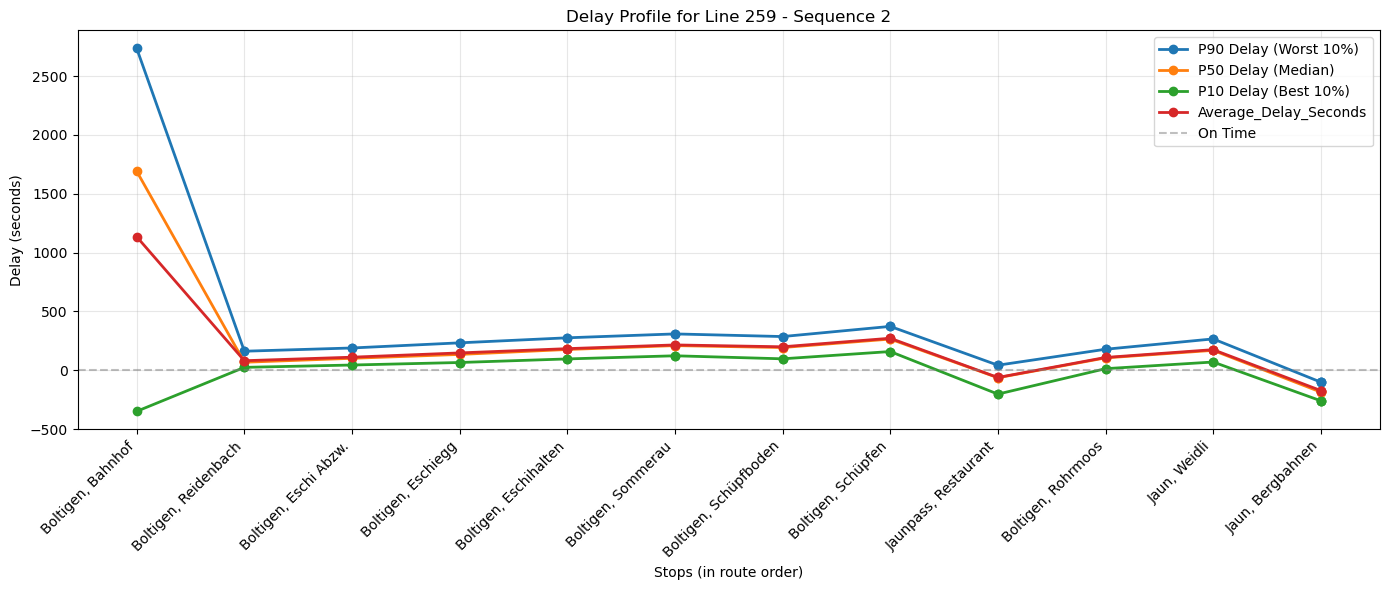

📊 Summary for Line 259 Sequence 2
  - Stops plotted: 24
  - Average P50 delay: 160.5 seconds
  - Worst stop (P90): Boltigen, Bahnhof (2734.5s)


In [21]:
import matplotlib.pyplot as plt

def plot_delay_profile_for_line(df, line_sequences, line, sequence_id=None):
    """
    Plot delay profile (P90, P50, P10) along the stops of a given line sequence.
    
    Parameters:
    df: DataFrame like stop_line_direction_delay_df
    line_sequences: Your line_sequences dictionary from sequence analysis
    line: Line number to visualize
    sequence_id: Optional. If specified, filters on this sequence/direction only
    
    Returns:
    Matplotlib plot showing delay profiles per stop
    """
    df_filtered = df[df['Line'] == line].copy()
    
    if sequence_id is not None:
        df_filtered = df_filtered[df_filtered['Direction'] == sequence_id]
    
    if df_filtered.empty:
        print("❌ No data found for the given line (and sequence if specified).")
        return
    
    # Get the correct order from sequence
    if sequence_id is not None and line in line_sequences and sequence_id in line_sequences[line]:
        # Get the sequence order using Didok IDs
        didok_sequence = line_sequences[line][sequence_id]
        
        # Create a mapping of Didok to position
        didok_to_position = {str(didok): i for i, didok in enumerate(didok_sequence)}
        
        # Add position column and sort by it
        df_filtered['Position'] = df_filtered['Didok'].astype(str).map(didok_to_position)
        df_filtered = df_filtered.dropna(subset=['Position']).sort_values('Position')
    else:
        # If no sequence specified, just sort by Didok (fallback)
        df_filtered = df_filtered.sort_values('Didok')
    
    if df_filtered.empty:
        print("❌ No matching stops found in the sequence data.")
        return
    
    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(df_filtered['StopName'], df_filtered['P90_Delay_Seconds'], 
             marker='o', linewidth=2, markersize=6, label='P90 Delay (Worst 10%)')
    plt.plot(df_filtered['StopName'], df_filtered['P50_Delay_Seconds'], 
             marker='o', linewidth=2, markersize=6, label='P50 Delay (Median)')
    plt.plot(df_filtered['StopName'], df_filtered['P10_Delay_Seconds'], 
             marker='o', linewidth=2, markersize=6, label='P10 Delay (Best 10%)')
    plt.plot(df_filtered['StopName'], df_filtered['Average_Delay_Seconds'],
             marker='o', linewidth=2, markersize=6, label='Average_Delay_Seconds')
    
    # Add zero line for reference
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='On Time')
    
    plt.title(f"Delay Profile for Line {line}" + 
              (f" - Sequence {sequence_id}" if sequence_id is not None else " (All Sequences)"))
    plt.xlabel("Stops (in route order)")
    plt.ylabel("Delay (seconds)")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"📊 Summary for Line {line}" + (f" Sequence {sequence_id}" if sequence_id else ""))
    print(f"  - Stops plotted: {len(df_filtered)}")
    print(f"  - Average P50 delay: {df_filtered['P50_Delay_Seconds'].mean():.1f} seconds")
    print(f"  - Worst stop (P90): {df_filtered.loc[df_filtered['P90_Delay_Seconds'].idxmax(), 'StopName']} ({df_filtered['P90_Delay_Seconds'].max():.1f}s)")

# Usage examples:
# Show all sequences for a line
# plot_delay_profile_for_line(stop_line_direction_delay_df, line_sequences, line=259)

# Show specific sequence
plot_delay_profile_for_line(stop_line_direction_delay_df, line_sequences, line=259, sequence_id=2)
# Ulmiz FR, Abzw. Lurtigen
# Châtel-St-Denis, Les Moilles 492
# Tafers, Oberdorf 123 182 917 181
# Ulmiz FR, Abzw. Lurtigen

## Line pasenger flow

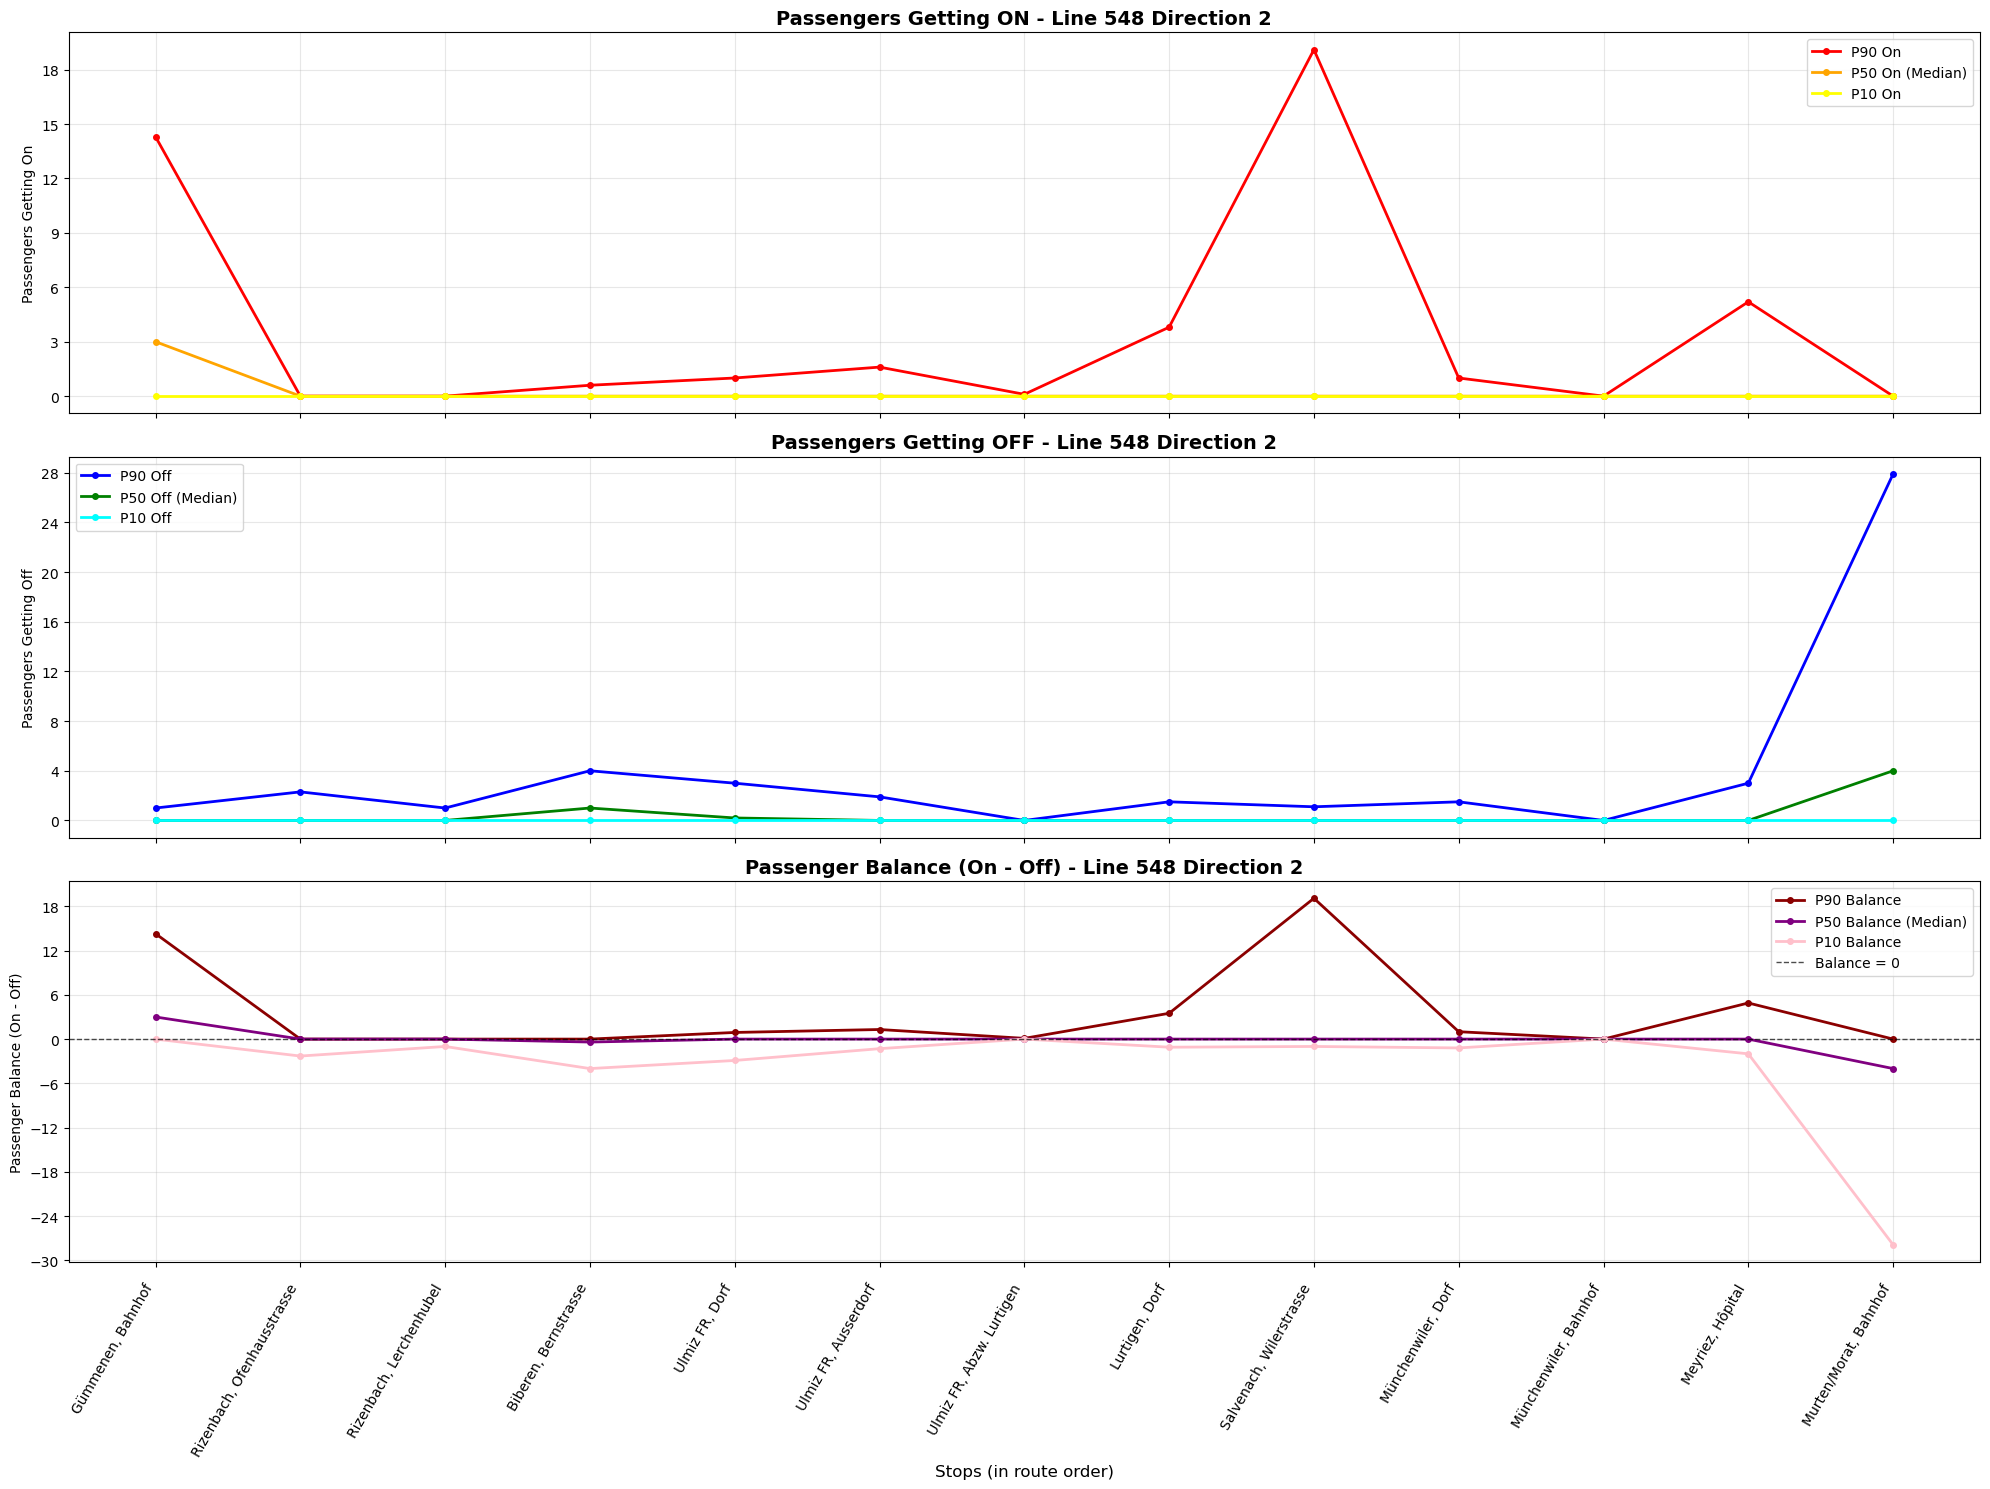

📊 Comprehensive Passenger Analysis for Line 548 Direction 2
  - Unique stops (platforms) analyzed: 13
  - Boarding-dominant stops (P50 > 0): 1
  - Alighting-dominant stops (P50 < 0): 2
  - Highest net boarding: Gümmenen, Bahnhof (+3.0 median)
  - Highest total boarding: Gümmenen, Bahnhof (3.0 median)
  - Highest net alighting: Murten/Morat, Bahnhof (-4.0 median)
  - Highest total alighting: Murten/Morat, Bahnhof (4.0 median)


In [22]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_passenger_comprehensive_profile_plcs(plcs_df, line_sequences, line, direction=None):
    """
    Plot comprehensive passenger profile using plcs_with_on_off DataFrame.
    
    Parameters:
    plcs_df: DataFrame (plcs_with_on_off data)
    line_sequences: Your line_sequences dictionary
    line: Line number to visualize
    direction: Direction ID (from your sequence analysis)
    """
    
    # Filter by line first
    df_filtered = plcs_df[plcs_df['Line'] == line].copy()
    
    if df_filtered.empty:
        print(f"❌ No data found for line {line}.")
        return
    
    # Filter by direction if specified
    if direction is not None:
        df_filtered = df_filtered[df_filtered['Direction'] == direction]
        if df_filtered.empty:
            print(f"❌ No data found for line {line}, direction {direction}.")
            return
    
    # Calculate total passengers and balance
    # Note: plcs_with_on_off only has Second_Class data, assuming First_Class = 0
    df_filtered['On_First_Class'] = 0.0  # Add missing First Class data
    df_filtered['Off_First_Class'] = 0.0  # Add missing First Class data
    
    df_filtered['Total_On'] = df_filtered['On_First_Class'] + df_filtered['On_Second_Class']
    df_filtered['Total_Off'] = df_filtered['Off_First_Class'] + df_filtered['Off_Second_Class']
    df_filtered['Total_Balance'] = df_filtered['Total_On'] - df_filtered['Total_Off']
    
    # Group by Stop ID first (the unique platform identifier)
    stop_stats = df_filtered.groupby('Stop').agg({
        'Total_On': [lambda x: x.quantile(0.1), lambda x: x.quantile(0.5), lambda x: x.quantile(0.9)],
        'Total_Off': [lambda x: x.quantile(0.1), lambda x: x.quantile(0.5), lambda x: x.quantile(0.9)],
        'Total_Balance': [lambda x: x.quantile(0.1), lambda x: x.quantile(0.5), lambda x: x.quantile(0.9)],
        'StopName': 'first',  # Get the stop name for each unique Stop ID
        'Didok': 'first'      # Get the Didok for each unique Stop ID
    }).round(1)
    
    # Flatten column names
    stop_stats.columns = [
        'On_P10', 'On_P50', 'On_P90', 
        'Off_P10', 'Off_P50', 'Off_P90',
        'Balance_P10', 'Balance_P50', 'Balance_P90',
        'StopName', 'Didok'
    ]
    stop_stats = stop_stats.reset_index()
    
    # Get sequence order using Didok IDs if direction specified
    if direction is not None and line in line_sequences and direction in line_sequences[line]:
        # Get the sequence order (Didok IDs)
        didok_sequence = line_sequences[line][direction]
        
        # Create a mapping of Didok to position
        didok_to_position = {str(didok): i for i, didok in enumerate(didok_sequence)}
        
        # Add position column and sort by it
        stop_stats['Position'] = stop_stats['Didok'].astype(str).map(didok_to_position)
        stop_stats = stop_stats.dropna(subset=['Position'])
        stop_stats = stop_stats.sort_values('Position')
    else:
        # If no direction specified, sort by Stop ID (fallback)
        stop_stats = stop_stats.sort_values('Stop')
    
    if stop_stats.empty:
        print("❌ No stops found after filtering and ordering.")
        return
    
    # Create three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15))
    
    # Plot 1: Passengers getting ON
    ax1.plot(stop_stats['StopName'], stop_stats['On_P90'], marker='o', label='P90 On', color='red', linewidth=2, markersize=4)
    ax1.plot(stop_stats['StopName'], stop_stats['On_P50'], marker='o', label='P50 On (Median)', color='orange', linewidth=2, markersize=4)
    ax1.plot(stop_stats['StopName'], stop_stats['On_P10'], marker='o', label='P10 On', color='yellow', linewidth=2, markersize=4)
    ax1.set_title(f"Passengers Getting ON - Line {line}" + (f" Direction {direction}" if direction else ""), fontsize=14, fontweight='bold')
    ax1.set_ylabel("Passengers Getting On")
    ax1.tick_params(axis='x', rotation=60, which='major', pad=10)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Plot 2: Passengers getting OFF
    ax2.plot(stop_stats['StopName'], stop_stats['Off_P90'], marker='o', label='P90 Off', color='blue', linewidth=2, markersize=4)
    ax2.plot(stop_stats['StopName'], stop_stats['Off_P50'], marker='o', label='P50 Off (Median)', color='green', linewidth=2, markersize=4)
    ax2.plot(stop_stats['StopName'], stop_stats['Off_P10'], marker='o', label='P10 Off', color='cyan', linewidth=2, markersize=4)
    ax2.set_title(f"Passengers Getting OFF - Line {line}" + (f" Direction {direction}" if direction else ""), fontsize=14, fontweight='bold')
    ax2.set_ylabel("Passengers Getting Off")
    ax2.tick_params(axis='x', rotation=60, which='major', pad=10)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Plot 3: Passenger Balance (On - Off)
    ax3.plot(stop_stats['StopName'], stop_stats['Balance_P90'], marker='o', label='P90 Balance', color='darkred', linewidth=2, markersize=4)
    ax3.plot(stop_stats['StopName'], stop_stats['Balance_P50'], marker='o', label='P50 Balance (Median)', color='purple', linewidth=2, markersize=4)
    ax3.plot(stop_stats['StopName'], stop_stats['Balance_P10'], marker='o', label='P10 Balance', color='pink', linewidth=2, markersize=4)
    
    # Zero line for balance reference
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.7, linewidth=1, label='Balance = 0')
    
    ax3.set_title(f"Passenger Balance (On - Off) - Line {line}" + (f" Direction {direction}" if direction else ""), fontsize=14, fontweight='bold')
    ax3.set_xlabel("Stops (in route order)", fontsize=12)
    ax3.set_ylabel("Passenger Balance (On - Off)")
    ax3.tick_params(axis='x', rotation=60, which='major', pad=10)
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    ax3.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Align x-tick labels for all subplots
    for ax in [ax1, ax2, ax3]:
        for label in ax.get_xticklabels():
            label.set_horizontalalignment('right')
    
    # Only show x-labels on the bottom plot
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive summary
    print(f"📊 Comprehensive Passenger Analysis for Line {line}" + (f" Direction {direction}" if direction else ""))
    print(f"  - Unique stops (platforms) analyzed: {len(stop_stats)}")
    # print(f"  - Data source: plcs_with_on_off (Second Class only)")
    
    # # Show stop details for verification
    # print(f"  - Stop details:")
    # for _, stop in stop_stats.iterrows():
    #     print(f"    • Stop ID {stop['Stop']}: {stop['StopName']} (Didok: {stop['Didok']})")
    
    # Analyze boarding vs alighting patterns
    boarding_stops = stop_stats[stop_stats['Balance_P50'] > 0]
    alighting_stops = stop_stats[stop_stats['Balance_P50'] < 0]
    
    print(f"  - Boarding-dominant stops (P50 > 0): {len(boarding_stops)}")
    print(f"  - Alighting-dominant stops (P50 < 0): {len(alighting_stops)}")
    
    if len(boarding_stops) > 0:
        max_boarding = boarding_stops.loc[boarding_stops['Balance_P50'].idxmax()]
        print(f"  - Highest net boarding: {max_boarding['StopName']} (+{max_boarding['Balance_P50']:.1f} median)")
        
        max_on = stop_stats.loc[stop_stats['On_P50'].idxmax()]
        print(f"  - Highest total boarding: {max_on['StopName']} ({max_on['On_P50']:.1f} median)")
    
    if len(alighting_stops) > 0:
        max_alighting = alighting_stops.loc[alighting_stops['Balance_P50'].idxmin()]
        print(f"  - Highest net alighting: {max_alighting['StopName']} ({max_alighting['Balance_P50']:.1f} median)")
        
        max_off = stop_stats.loc[stop_stats['Off_P50'].idxmax()]
        print(f"  - Highest total alighting: {max_off['StopName']} ({max_off['Off_P50']:.1f} median)")

# Usage:
plot_passenger_comprehensive_profile_plcs(plcs_with_on_off, line_sequences, line=548, direction=2)

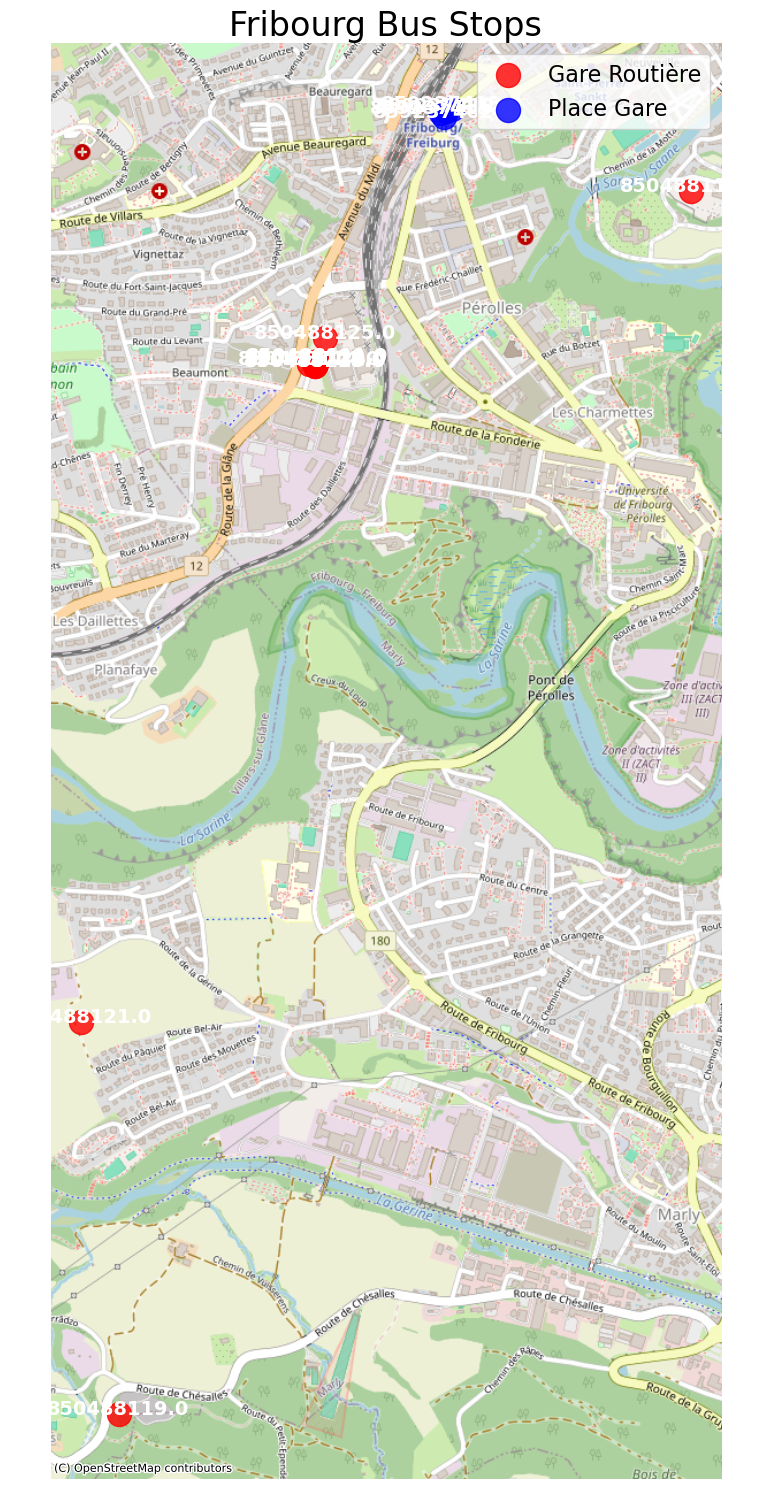

Found 16 unique stops
           Stop                          StopName  On_Second_Class
0   850488111.0  Fribourg/Freiburg, gare routière          5660.87
1   850488112.0  Fribourg/Freiburg, gare routière          9961.18
2   850488114.0  Fribourg/Freiburg, gare routière          8342.76
3   850488115.0  Fribourg/Freiburg, gare routière          4948.61
4   850488116.0  Fribourg/Freiburg, gare routière          3361.56
5   850488117.0  Fribourg/Freiburg, gare routière          3823.29
6   850488118.0  Fribourg/Freiburg, gare routière          2852.05
7   850488119.0  Fribourg/Freiburg, gare routière          7815.24
8   850488120.0  Fribourg/Freiburg, gare routière          4562.36
9   850488121.0  Fribourg/Freiburg, gare routière          8265.52
10  850488122.0  Fribourg/Freiburg, gare routière          5000.68
11  850488125.0  Fribourg/Freiburg, gare routière          4791.45
12  859237402.0       Fribourg/Freiburg, Pl. Gare             0.00
13  859237411.0       Fribourg/Freiburg,